# Final Project - Group 7

Dan Arday,
Mythreyi Thirumalai, &
Stephanie M Tabares

# Introduction

This notebook explores anomaly detection in video sequences using the UCSD Anomaly Detection Dataset. The dataset consists of grayscale pedestrian walkway videos divided into two subsets, UCSDped1 and UCSDped2, which differ in perspective and frame counts. UCSDped1 has a higher perspective distortion due to its elevated camera angle, while UCSDped2 captures lateral motion with minimal distortion. Both datasets contain labeled anomalies, such as bikes or vehicles, within crowded pedestrian scenes.

The main challenge was to design a model capable of distinguishing between normal and anomalous frames. Where those with pedestrians alone were considered *normal* and those with bikes, scooters, and cars weaving through were considered *anomalous*. In our EDA we discovered that the dataset has low resolution, noisy footage, and heavy class imbalance favoring normal behavior. To address this, we explored two approaches: a frame-based autoencoder to reconstruct and identify anomalies and a sequence-based hybrid model combining convolutional and temporal layers to detect anomalies across frames. This notebook details our efforts, including data preprocessing, model development, and evaluation, while highlighting the challenges and insights gained from working with this dataset.

https://www.kaggle.com/datasets/karthiknm1/ucsd-anomaly-detection-dataset

# Loading Data from Drive

#### Imports and pip

In [1]:
!pip install -q torch torchvision opencv-python matplotlib
!pip install -q numpy pandas tensorflow

In [67]:
# File and directory handling
import os
import re
import tarfile
import zipfile
from glob import glob

# Data handling
import numpy as np
from pandas import DataFrame

# Image and video processing
import cv2
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Video
from scipy.stats import pearsonr

# Colab-specific utilities
from google.colab import drive, files
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Machine Learning
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from tensorflow.keras import Model, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import Precision, Recall, AUC

#### Mount Files

Unzips data and loads content in drive. Note the code above must be re-run everytime you connect to a new colab session.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define paths
zip_path = '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2.zip'
tar_path = '/content/drive/MyDrive/UCSD_Anomaly_Dataset.tar.gz'
extract_to = '/content/UCSD_Anomaly_Dataset'

# Create the extraction folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Check and extract the dataset
if os.path.exists(zip_path):
    print(f"Extracting from zip file: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
elif os.path.exists(tar_path):
    print(f"Extracting from tar file: {tar_path}")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(extract_to)
else:
    print("Error: Neither zip nor tar file was found. Please upload the dataset.")

# Check the contents of the extracted folder
print("Extracted folder contents:")
print(os.listdir(extract_to))


Extracting from zip file: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2.zip
Extracted folder contents:
['UCSDped1', '._README.txt', 'UCSDped2', 'README.txt', 'README.txt~']


#### Directory Structure Exploration

In [5]:
# Define paths for Ped1 and Ped2 datasets
if (os.path.exists('/content/UCSD_Anomaly_Dataset')):
  base_path = '/content/UCSD_Anomaly_Dataset'
else:
  base_path = '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2'

print("Base path:", base_path)

ped1_path = os.path.join(base_path, 'UCSDped1')
ped2_path = os.path.join(base_path, 'UCSDped2')

# Explore directory structure
print("UCSDped1 contents:", os.listdir(ped1_path))
print("UCSDped2 contents:", os.listdir(ped2_path))

Base path: /content/UCSD_Anomaly_Dataset
UCSDped1 contents: ['Test', 'Train']
UCSDped2 contents: ['Test', 'Train']


#### Dataset Overview

In [6]:
print("# Dataset Overview")
print("This block provides an overview of the dataset folder structure.")

def dataset_overview(path):
    class_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            class_counts[folder] = len(os.listdir(folder_path))
    return class_counts

ped1_test_path = os.path.join(ped1_path, 'Test')
ped2_test_path = os.path.join(ped2_path, 'Test')

print("UCSDped1 Test Folder Overview:", dataset_overview(ped1_test_path))
print("UCSDped2 Test Folder Overview:", dataset_overview(ped2_test_path))

test_folder_path = os.path.join(ped1_test_path, 'Test001')
print("Files in Test001 folder:", os.listdir(test_folder_path))

# Dataset Overview
This block provides an overview of the dataset folder structure.
UCSDped1 Test Folder Overview: {'Test021': 200, 'Test002': 200, 'Test016': 200, 'Test019_gt': 200, 'Test003_gt': 200, 'Test004_gt': 200, 'Test026': 200, 'Test031': 200, 'Test017': 200, 'Test035': 200, 'Test003': 200, 'Test019': 200, 'Test032': 200, 'Test010': 200, 'Test022_gt': 200, 'Test011': 200, 'Test009': 200, 'Test001': 200, 'Test018': 200, 'Test014': 200, 'Test029': 200, 'Test021_gt': 200, 'Test023': 200, 'Test018_gt': 200, 'Test033': 200, 'Test004': 200, 'Test023_gt': 200, 'Test027': 200, 'Test005': 200, 'Test015': 200, 'Test025': 200, 'Test028': 200, 'Test024_gt': 200, 'Test030': 200, 'Test013': 200, 'Test012': 200, 'Test014_gt': 200, 'Test006': 200, 'Test036': 200, 'Test008': 200, 'Test034': 200, 'Test032_gt': 200, 'Test024': 200, 'Test007': 200, 'Test020': 200, 'Test022': 200}
UCSDped2 Test Folder Overview: {'Test002': 180, 'Test008_gt': 180, 'Test003_gt': 150, 'Test004_gt': 180, 'Test002_gt':

# EDA

Generic Function for displaying a frame

In [7]:
def display_frame(dataset, split, folder, frame_index):
    """
    Display a frame from the UCSD Anomaly Dataset.

    Parameters:
        dataset (int or str): 1, 2, "UCSDped1", or "UCSDped2".
        split (str): "Test" or "Train".
        folder (str): Folder name (e.g., "001").
        frame_index (int): Frame number to display.
    """
    # Determine dataset name
    if isinstance(dataset, int):
        if dataset == 1:
            dataset_name = "UCSDped1"
        elif dataset == 2:
            dataset_name = "UCSDped2"
        else:
            raise ValueError("Invalid dataset. Use 1, 2, 'UCSDped1', or 'UCSDped2'.")
    elif isinstance(dataset, str):
        if dataset in ["UCSDped1", "UCSDped2"]:
            dataset_name = dataset
        else:
            raise ValueError("Invalid dataset. Use 1, 2, 'UCSDped1', or 'UCSDped2'.")
    else:
        raise TypeError("Dataset must be an integer or string.")

    # Construct the file path
    frame_filename = f"{frame_index:03d}.tif"
    file_path = os.path.join(
        "/content/UCSD_Anomaly_Dataset",
        dataset_name,
        split,
        f"{split}{folder}",
        frame_filename
    )

    # Check if file exists
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Frame not found: {file_path}")

    # Open and display the frame
    frame = Image.open(file_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(frame, cmap="gray")
    plt.axis("off")
    plt.title(f"Frame {frame_index} from {dataset_name}/{split}/{folder}")
    plt.show()

## Load the Frames

In [26]:
# Define path to the Test001 folder
frame_folder = os.path.join(ped1_test_path, 'Test001')

# List all frame files and sort them to ensure sequential order
frames = sorted([f for f in os.listdir(frame_folder) if f.endswith('.tif')])

# Returns all frames from Ped1 and Ped2 datasets as separate lists, in a
def load_frames():
    ped1_frames = []
    ped2_frames = []
    dataset_folder = "/content/UCSD_Anomaly_Dataset"

    # Define paths for Ped1 and Ped2 folders
    ped1_folder = os.path.join(dataset_folder, "UCSDped1")
    ped2_folder = os.path.join(dataset_folder, "UCSDped2")

    # Collect all frames for Ped1
    if os.path.exists(ped1_folder):
        for root, _, files in os.walk(ped1_folder):
            tif_files = sorted([os.path.join(root, f) for f in files if f.endswith('.tif')])
            ped1_frames.extend(tif_files)

    # Collect all frames for Ped2
    if os.path.exists(ped2_folder):
        for root, _, files in os.walk(ped2_folder):
            tif_files = sorted([os.path.join(root, f) for f in files if f.endswith('.tif')])
            ped2_frames.extend(tif_files)

    return ped1_frames, ped2_frames

ped1_frames, ped2_frames = load_frames()

print(f"Total Ped1 frames: {len(ped1_frames)}")
print(f"Total Ped2 frames: {len(ped2_frames)}")


Total Ped1 frames: 14000
Total Ped2 frames: 4560


## Visualize Frames


# Frame-Level Visualization
This block displays sample frames from the dataset.
Example of frames from Ped1_Test001:


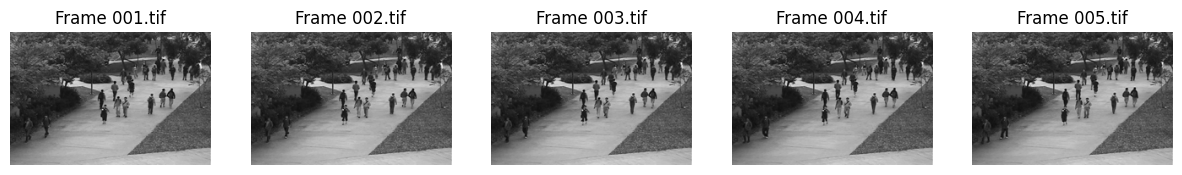

Example of frames from Ped2_Train003:


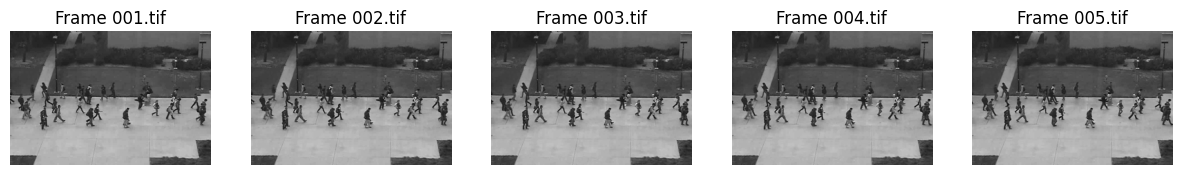

In [10]:
print("\n# Frame-Level Visualization")
print("This block displays sample frames from the dataset.")

def visualize_frames(folder_path, num_frames=5):
    frames = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i, frame_file in enumerate(frames[:num_frames]):
        frame_path = os.path.join(folder_path, frame_file)
        frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(frame, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Frame {frame_file}")
    plt.show()

print("Example of frames from Ped1_Test001:")
p1_test001_path = os.path.join(ped1_path, 'Test', 'Test001')
visualize_frames(p1_test001_path)

print("Example of frames from Ped2_Train003:")
p2_train003_path = os.path.join(ped2_path, 'Train', 'Train003')
visualize_frames(p2_train003_path)

## Basic Distribution and Frame Statsitics

In [11]:
# Inspect properties of a single frame
sample_frame_path = os.path.join(frame_folder, frames[0])
frame = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)

print(f"Frame shape: {frame.shape}")
print(f"Pixel intensity range: {frame.min()} - {frame.max()}")

means = []
std_devs = []

# Loop through frames to calculate stats
for frame_file in frames:
    frame_path = os.path.join(frame_folder, frame_file)
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    means.append(np.mean(frame))
    std_devs.append(np.std(frame))

print(f"Mean Pixel Intensity: {np.mean(means):.2f}")
print(f"Standard Deviation of Pixel Intensity: {np.mean(std_devs):.2f}")

Frame shape: (158, 238)
Pixel intensity range: 0 - 250
Mean Pixel Intensity: 97.94
Standard Deviation of Pixel Intensity: 52.84


Verifying the consistency of frame sizes

In [12]:
folders = [
    '/content/UCSD_Anomaly_Dataset/UCSDped1/Train/Train001',
    '/content/UCSD_Anomaly_Dataset/UCSDped1/Test/Test001',
    '/content/UCSD_Anomaly_Dataset/UCSDped2/Train/Train001',
    '/content/UCSD_Anomaly_Dataset/UCSDped2/Test/Test001'
]
for folder in folders:
    frame_files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
    frame_path = os.path.join(folder, frame_files[0])
    frame = cv2.imread(frame_path, cv2.IMREAD_COLOR)
    print(f"Folder: {folder}, Frame shape: {frame.shape}")

Folder: /content/UCSD_Anomaly_Dataset/UCSDped1/Train/Train001, Frame shape: (158, 238, 3)
Folder: /content/UCSD_Anomaly_Dataset/UCSDped1/Test/Test001, Frame shape: (158, 238, 3)
Folder: /content/UCSD_Anomaly_Dataset/UCSDped2/Train/Train001, Frame shape: (240, 360, 3)
Folder: /content/UCSD_Anomaly_Dataset/UCSDped2/Test/Test001, Frame shape: (240, 360, 3)


## Distribution of Pixel Intensity

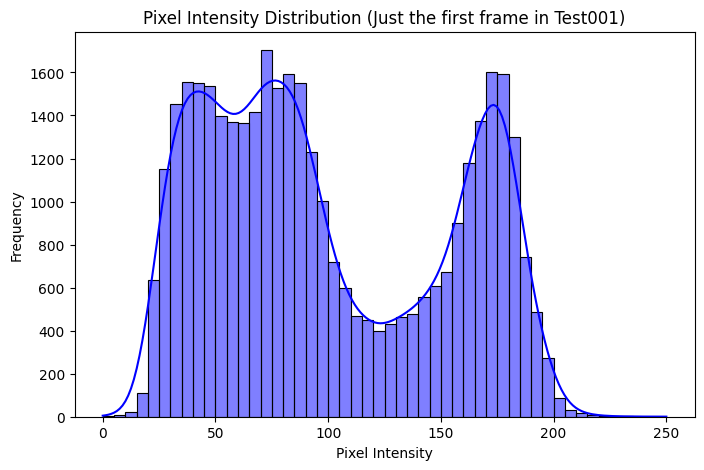

In [13]:
# Inspect properties of a single frame
sample_frame_path = os.path.join(frame_folder, frames[0])
frame = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)

# Flatten the pixel values into a 1D array for histogram
pixel_values = frame.flatten()

# Plot histogram of pixel intensities
plt.figure(figsize=(8, 5))
sns.histplot(pixel_values, bins=50, kde=True, color="blue")
plt.title("Pixel Intensity Distribution (Just the first frame in Test001)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")  # Correct ylabel usage
plt.show()

(Had to sample here due to length of processing time)

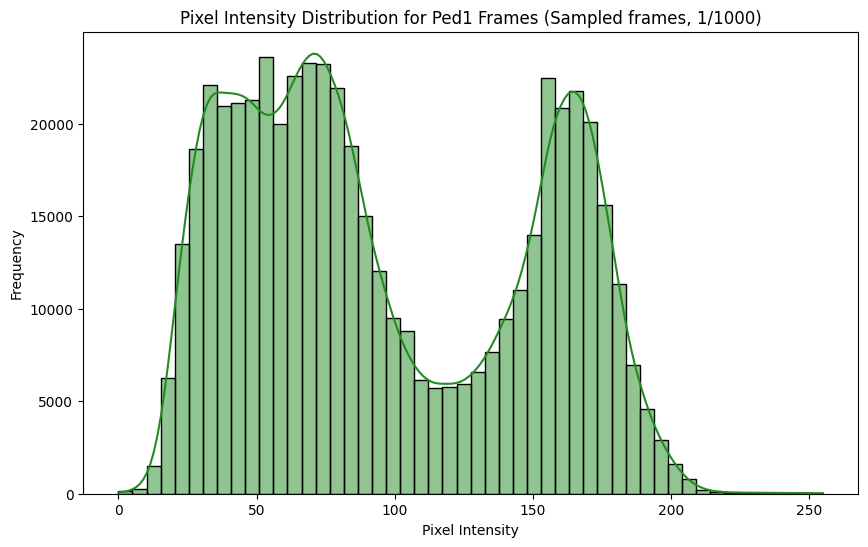

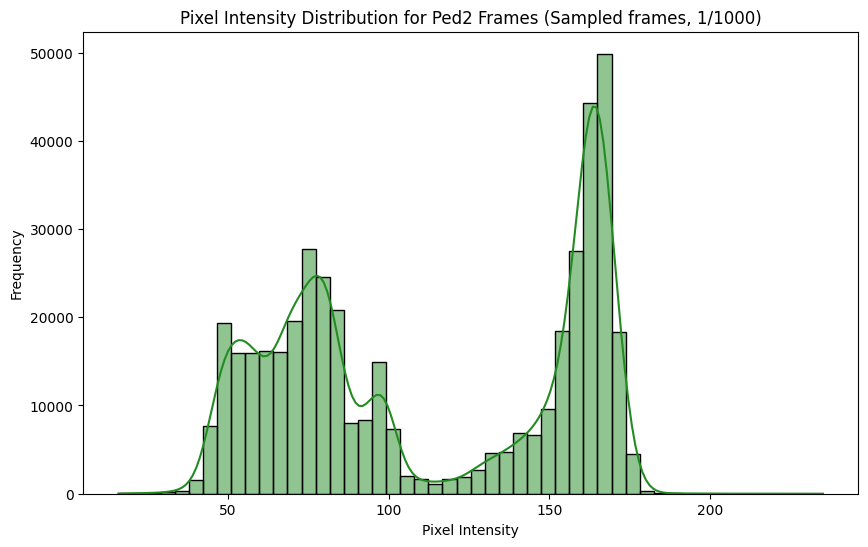

In [18]:
def plot_pixel_distribution_sampled_frames(frame_paths, title, sample_rate=10):
    """
    Plot the pixel intensity distribution across sampled frames.

    Parameters:
        frame_paths (list): List of file paths for all frames.
        title (str): Title for the plot.
        sample_rate (int): Interval for sampling frames (e.g., every nth frame).
    """
    all_pixel_values = []

    for i, frame_path in enumerate(frame_paths):
        if i % sample_rate == 0:  # Only process every nth frame
            frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
            all_pixel_values.extend(frame.flatten())

    plt.figure(figsize=(10, 6))
    sns.histplot(all_pixel_values, bins=50, kde=True, color="#228B22")
    plt.title(f"Pixel Intensity Distribution for {title} (Sampled frames, 1/{sample_rate})")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

sample_rate = 1000
# Use sampling to speed up the process
plot_pixel_distribution_sampled_frames(ped1_frames, "Ped1 Frames", sample_rate=sample_rate)
plot_pixel_distribution_sampled_frames(ped2_frames, "Ped2 Frames", sample_rate=sample_rate)

## Compare Multiple Frames

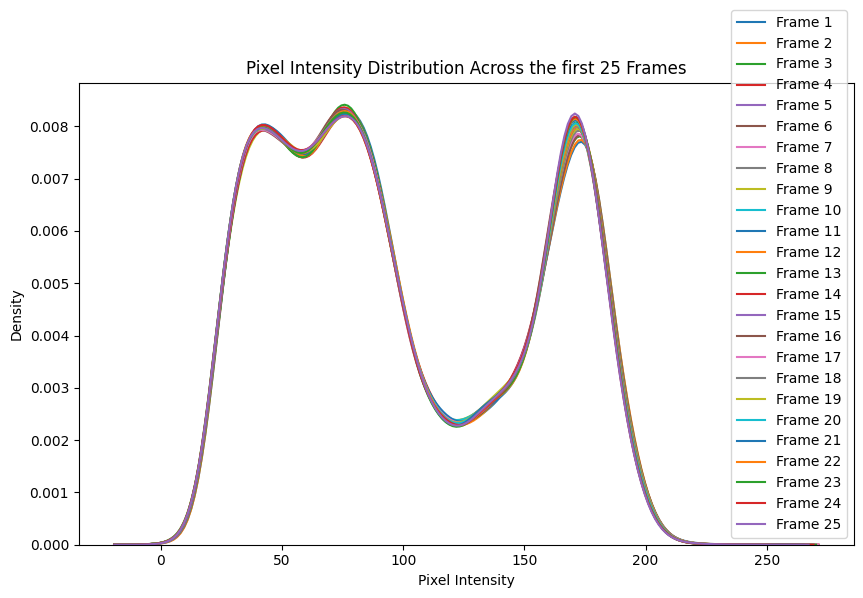

In [ ]:
frames_to_compare = frames[:25]  # First 25 frames
all_pixel_values = []

# Collect pixel values for each frame
for frame_file in frames_to_compare:
    frame_path = os.path.join(frame_folder, frame_file)
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    all_pixel_values.append(frame.flatten())

# Plot each frame's pixel intensity distribution
plt.figure(figsize=(10, 6))
for i, pixel_values in enumerate(all_pixel_values):
    sns.kdeplot(pixel_values, label=f"Frame {i+1}")

plt.title("Pixel Intensity Distribution Across the first 25 Frames")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.legend()
plt.show()

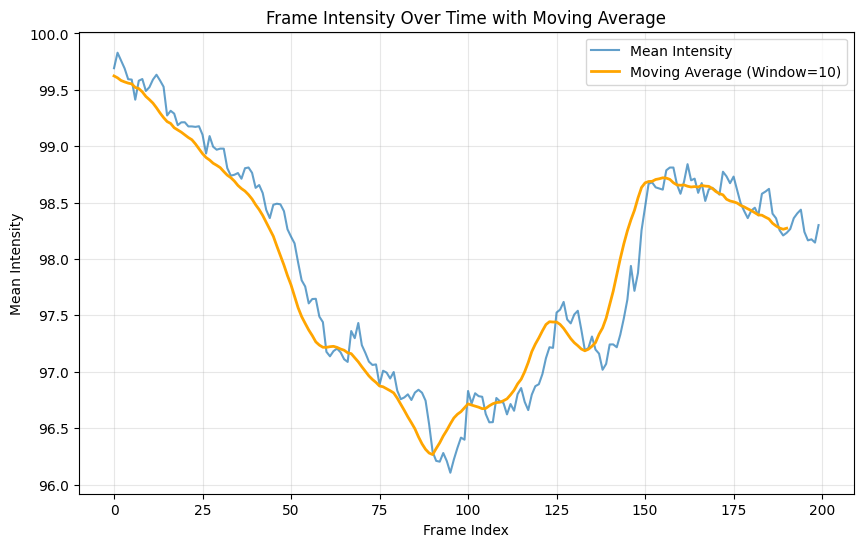

In [ ]:
# Moving average calculation
window = 10
moving_avg = np.convolve(means, np.ones(window) / window, mode='valid')

# Combined plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(means)), means, label='Mean Intensity', alpha=0.7)
plt.plot(range(len(moving_avg)), moving_avg, label=f'Moving Average (Window={window})', linewidth=2, color='orange')
plt.title("Frame Intensity Over Time with Moving Average")
plt.xlabel("Frame Index")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Frame Differences (Motion Analysis)

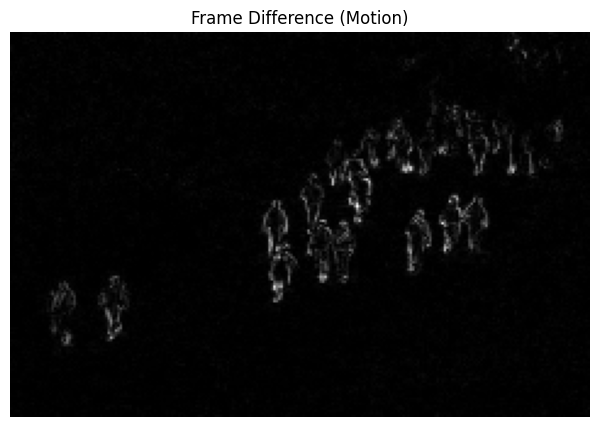

In [ ]:
# Compute difference between first two frames
frame1 = cv2.imread(os.path.join(frame_folder, frames[0]), cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread(os.path.join(frame_folder, frames[1]), cv2.IMREAD_GRAYSCALE)

frame_diff = cv2.absdiff(frame1, frame2)

# Visualize the difference
plt.figure(figsize=(8, 5))
plt.imshow(frame_diff, cmap='gray')
plt.title("Frame Difference (Motion)")
plt.axis('off')
plt.show()

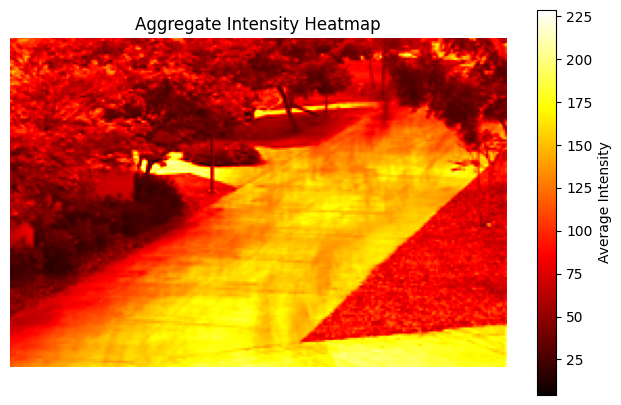

In [ ]:
heatmap = np.zeros_like(np.array(Image.open(os.path.join(frame_folder, frames[0]))), dtype=np.float32)

for frame_file in frames:
    frame = np.array(Image.open(os.path.join(frame_folder, frame_file)))
    heatmap += frame

heatmap /= len(frames)  # Normalize by number of frames

plt.figure(figsize=(8, 5))
plt.imshow(heatmap, cmap='hot')
plt.title("Aggregate Intensity Heatmap")
plt.axis("off")
plt.colorbar(label="Average Intensity")
plt.show()

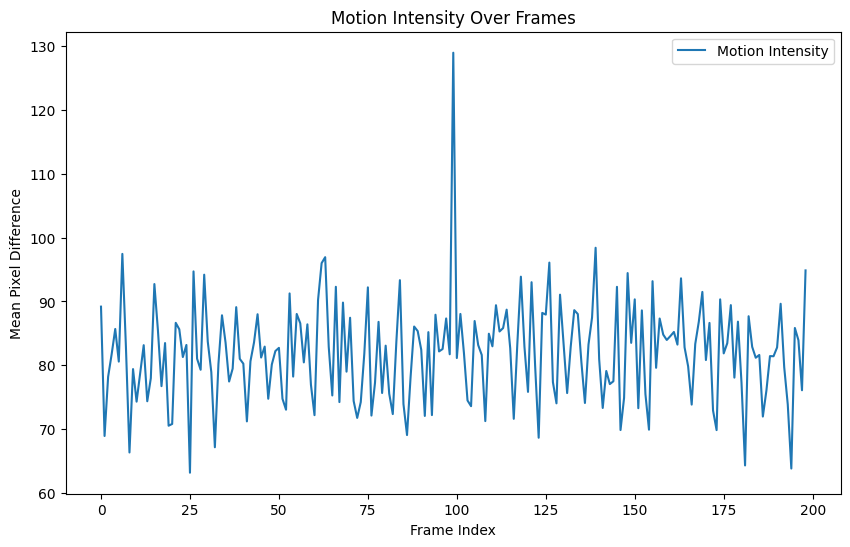

In [ ]:
frame_diffs = []
for i in range(len(frames) - 1):
    frame1 = np.array(Image.open(os.path.join(frame_folder, frames[i])))
    frame2 = np.array(Image.open(os.path.join(frame_folder, frames[i+1])))
    diff = np.abs(frame1 - frame2)
    frame_diffs.append(np.mean(diff))  # Mean difference for each frame pair

# Plot motion intensity over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(frame_diffs)), frame_diffs, label="Motion Intensity")
plt.title("Motion Intensity Over Frames")
plt.xlabel("Frame Index")
plt.ylabel("Mean Pixel Difference")
plt.legend()
plt.show()

## Analysis on Anomalies

### Examples of Anomalies

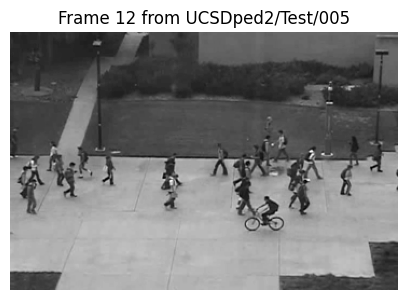

In [8]:
display_frame("UCSDped2", "Test", "005", 12)

Number of frames: 200
Number of ground truth files: 200


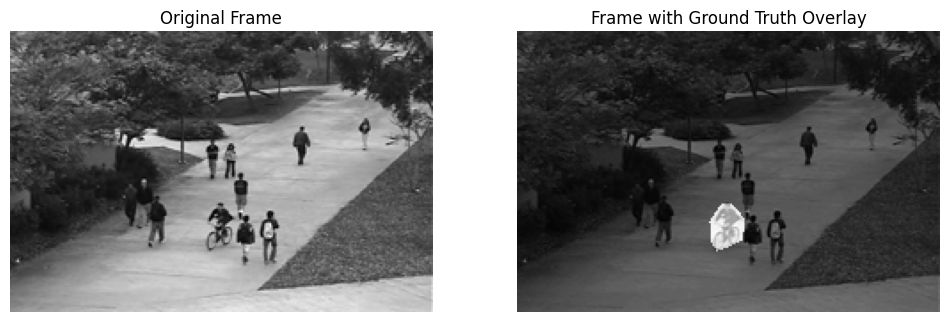

In [ ]:
# Define paths
test_folder = os.path.join(ped1_path, 'Test', 'Test032')
gt_folder = os.path.join(ped1_path, 'Test', 'Test032_gt')

# List frame and ground truth files
frame_files = sorted([f for f in os.listdir(test_folder) if f.endswith('.tif')])
gt_files = sorted([f for f in os.listdir(gt_folder) if f.endswith('.bmp')])

print(f"Number of frames: {len(frame_files)}")
print(f"Number of ground truth files: {len(gt_files)}")

# Ensure frame_index is within range
frame_index = 96
if frame_index >= len(gt_files):
    print(f"No ground truth file for frame {frame_files[frame_index]}.")
else:
    # Load frame and corresponding ground truth
    frame_path = os.path.join(test_folder, frame_files[frame_index])
    gt_path = os.path.join(gt_folder, gt_files[frame_index])

    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    # Normalize the ground truth mask to [0, 1] for blending
    gt_mask_normalized = (gt_mask > 0).astype(np.float32)  # Convert mask to binary (1 for anomaly, 0 otherwise)

    # Apply alpha blending (Opacity)
    opacity = 0.2
    overlay = (opacity * gt_mask_normalized * 255 + 0.2 * frame).astype(np.uint8)  # Blend the mask with the frame

    # Plot frame and overlay
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Frame")
    plt.imshow(frame, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Frame with Ground Truth Overlay")
    plt.imshow(overlay, cmap='gray')
    plt.axis("off")

    plt.show()

The frame on the left demonstrates what a base-frame looks like. The frame on the right is a ground-truth frame (in a folder ending with _gt) that highlights where an anomaly is. Here we can see it is attempting to hilight the biker as an anomaly.

### Test003 has an anomaly in it, where as Test001 does not. Let's compare them.

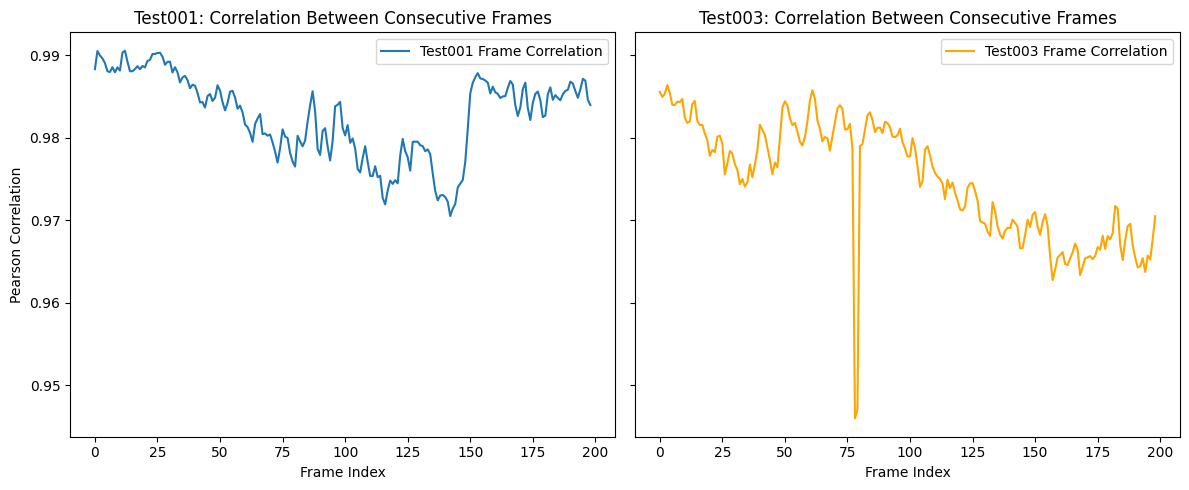

In [ ]:
def compute_correlations(folder_path):
    """Compute Pearson correlation between consecutive frames."""
    frames = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
    corrs = []
    for i in range(len(frames) - 1):
        frame1 = np.array(Image.open(os.path.join(folder_path, frames[i]))).flatten()
        frame2 = np.array(Image.open(os.path.join(folder_path, frames[i+1]))).flatten()
        corrs.append(pearsonr(frame1, frame2)[0])
    return corrs

# Define paths for Test001 and Test003
test001_folder = os.path.join(ped1_test_path, 'Test001')
test003_folder = os.path.join(ped1_test_path, 'Test003')

# Compute correlations for both
corrs_test001 = compute_correlations(test001_folder)
corrs_test003 = compute_correlations(test003_folder)

# Plot side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Test001
axes[0].plot(range(len(corrs_test001)), corrs_test001, label="Test001 Frame Correlation")
axes[0].set_title("Test001: Correlation Between Consecutive Frames")
axes[0].set_xlabel("Frame Index")
axes[0].set_ylabel("Pearson Correlation")
axes[0].legend()

# Test003
axes[1].plot(range(len(corrs_test003)), corrs_test003, label="Test003 Frame Correlation", color="orange")
axes[1].set_title("Test003: Correlation Between Consecutive Frames")
axes[1].set_xlabel("Frame Index")
axes[1].legend()

plt.tight_layout()
plt.show()

Here we can see that the cause for this dip in Pearson coorelation was due to noise in the dataset (aka it's grainy security cam footage.) This noise may cause challenges when attempting to train.

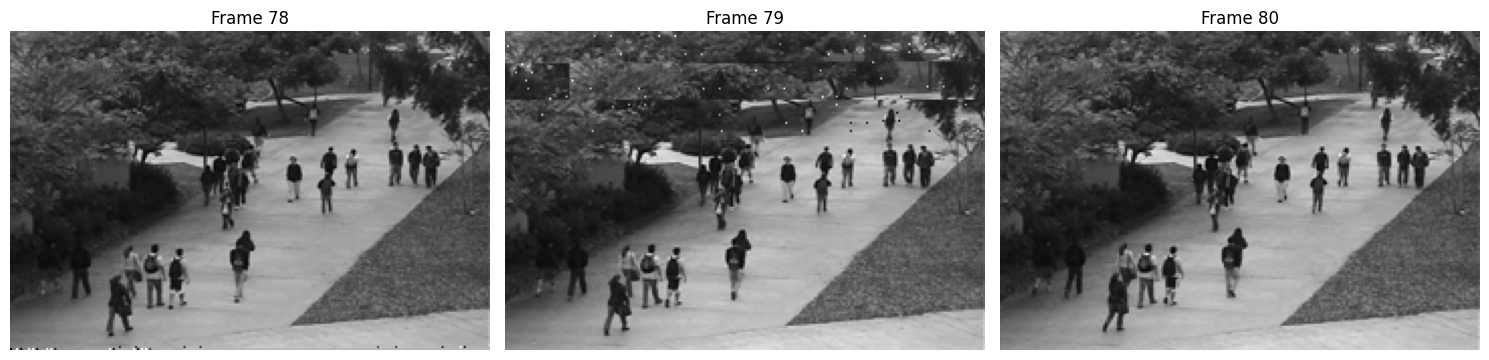

In [ ]:
def visualize_frames(folder_path, frame_index):
    """Visualize a specific frame and its neighbors."""
    frames = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
    # Ensure indices are valid
    indices = [max(0, frame_index - 1), frame_index, min(len(frames) - 1, frame_index + 1)]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, idx in enumerate(indices):
        frame_path = os.path.join(folder_path, frames[idx])
        frame = np.array(Image.open(frame_path))
        axes[i].imshow(frame, cmap='gray')
        axes[i].set_title(f"Frame {idx}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize frames around the anomaly in Test003
test003_folder = os.path.join(ped1_test_path, 'Test003')
visualize_frames(test003_folder, frame_index=79)

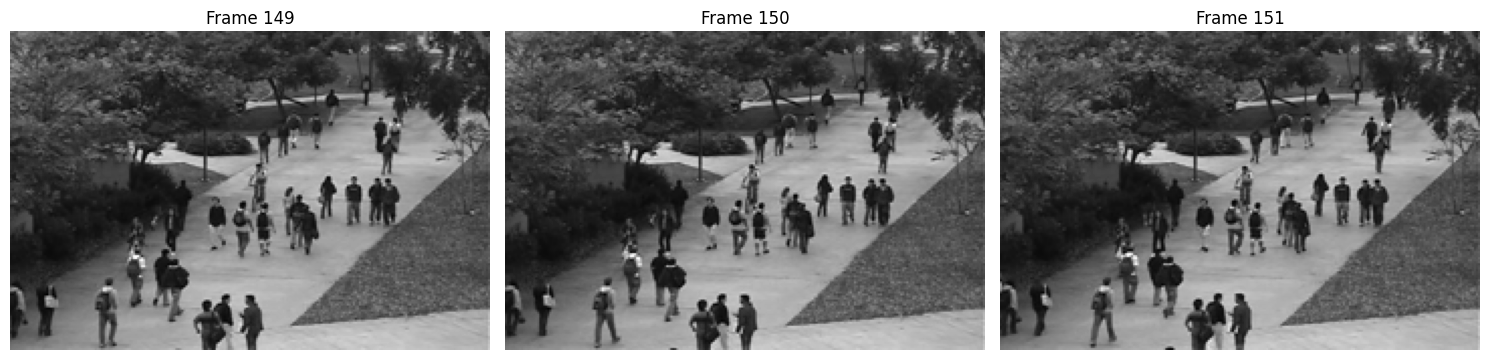

In [ ]:
# Visualize frames around the anomaly in Test003
test003_folder = os.path.join(ped1_test_path, 'Test003')
visualize_frames(test003_folder, frame_index=150)

Looking at frame 150, where the Pearson coorelation also dipped we can see there was an anomaly in the video (person on a scooter), along with a larger crowd. This may prove to be an effective metric for gauging anomalies going forward, at the cost of maybe flagging noise.

### Viewing a Sample Video

In [ ]:
# Ensure correct grayscale to BGR conversion
for frame_file in frames[:5]:  # Debugging first 5 frames
    frame_path = os.path.join(frame_folder, frame_file)
    frame = Image.open(frame_path)
    frame_np = np.array(frame)  # Convert to NumPy array

    # Convert to BGR
    try:
        frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
        print(f"Frame {frame_file} successfully converted to BGR format.")
    except Exception as e:
        print(f"Error converting frame {frame_file}: {e}")

Frame 001.tif successfully converted to BGR format.
Frame 002.tif successfully converted to BGR format.
Frame 003.tif successfully converted to BGR format.
Frame 004.tif successfully converted to BGR format.
Frame 005.tif successfully converted to BGR format.


In [ ]:
def create_video_from_pillow_frames(frame_folder, output_video_path, fps=20):
    # List all frame files and sort them
    frames = sorted([os.path.join(frame_folder, f) for f in os.listdir(frame_folder) if f.endswith('.tif')])

    # Read the first frame to get dimensions
    first_frame = Image.open(frames[0])
    width, height = first_frame.size

    # Define video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Write each frame into the video
    for frame_file in frames:
        frame = Image.open(frame_file)  # Read using Pillow
        frame_np = np.array(frame)  # Convert to NumPy array

        # Ensure pixel values are within [0, 255]
        frame_np = np.clip(frame_np, 0, 255).astype(np.uint8)

        # Convert grayscale to BGR
        frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_GRAY2BGR)

        # Write to the video
        video_writer.write(frame_bgr)

    video_writer.release()
    print(f"Video created at: {output_video_path}")

output_video_path = '/content/test_video.mp4'
create_video_from_pillow_frames(frame_folder, output_video_path)

Video created at: /content/test_video.mp4


In [ ]:
cap = cv2.VideoCapture(output_video_path)
if not cap.isOpened():
    print("Error: Unable to open the video file.")
else:
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Video dimensions: {width}x{height}, FPS: {fps}")
cap.release()

Video dimensions: 238x158, FPS: 20


In [ ]:
# Display the fixed video (Doesn't appear to work here, but the video will download locally in the next block)
Video(output_video_path, embed=True, width=600, height=400)

In [ ]:
#Saving it locally
# Download the video file
files.download(output_video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Temporal Analysis

Frame counts per test video in Ped1: {'Test005': 200, 'Test009': 200, 'Test004': 200, 'Test011': 200, 'Test008': 200, 'Test018_gt': 200, 'Test032_gt': 200, 'Test022_gt': 200, 'Test002': 200, 'Test027': 200, 'Test001': 200, 'Test018': 200, 'Test025': 200, 'Test003_gt': 200, 'Test028': 200, 'Test035': 200, 'Test022': 200, 'Test003': 200, 'Test019_gt': 200, 'Test014': 200, 'Test020': 200, 'Test006': 200, 'Test014_gt': 200, 'Test024_gt': 200, 'Test023_gt': 200, 'Test015': 200, 'Test031': 200, 'Test023': 200, 'Test033': 200, 'Test032': 200, 'Test012': 200, 'Test036': 200, 'Test034': 200, 'Test016': 200, 'Test030': 200, 'Test007': 200, 'Test004_gt': 200, 'Test029': 200, 'Test010': 200, 'Test024': 200, 'Test017': 200, 'Test013': 200, 'Test019': 200, 'Test026': 200, 'Test021': 200, 'Test021_gt': 200}
Frame counts per test video in Ped2: {'Test005': 150, 'Test005_gt': 150, 'Test006_gt': 180, 'Test009': 120, 'Test004': 180, 'Test011': 180, 'Test008': 180, 'Test002': 180, 'Test001_gt': 180, 'Test

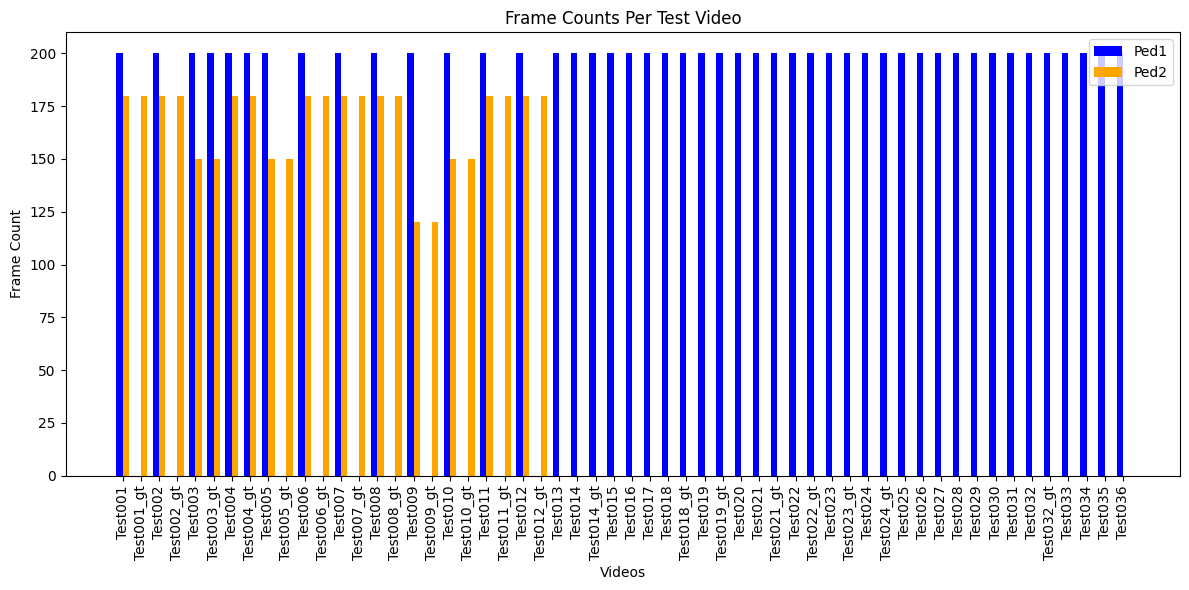

In [ ]:
# Temporal Frame Count (Video Perspective)
def visualize_frame_counts(frame_counts_ped1, frame_counts_ped2):
    # Extract video names and frame counts
    videos_ped1 = list(frame_counts_ped1.keys())
    counts_ped1 = list(frame_counts_ped1.values())

    videos_ped2 = list(frame_counts_ped2.keys())
    counts_ped2 = list(frame_counts_ped2.values())

    # Ensure both datasets align (shared x-axis)
    all_videos = sorted(set(videos_ped1 + videos_ped2))
    ped1_counts_aligned = [frame_counts_ped1.get(video, 0) for video in all_videos]
    ped2_counts_aligned = [frame_counts_ped2.get(video, 0) for video in all_videos]

    # Plot side-by-side bar chart
    x = np.arange(len(all_videos))  # Video indices
    width = 0.35  # Width of each bar

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, ped1_counts_aligned, width, label='Ped1', color='blue')
    ax.bar(x + width/2, ped2_counts_aligned, width, label='Ped2', color='orange')

    # Add labels and legend
    ax.set_xlabel('Videos')
    ax.set_ylabel('Frame Count')
    ax.set_title('Frame Counts Per Test Video')
    ax.set_xticks(x)
    ax.set_xticklabels(all_videos, rotation=90)
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

def count_frames(path):
    frame_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            frame_counts[folder] = len([f for f in os.listdir(folder_path) if f.endswith(('.tif', '.bmp'))])
    return frame_counts


# Visualize the frame counts
frame_counts_ped1 = count_frames(os.path.join(ped1_path, 'Test'))
frame_counts_ped2 = count_frames(os.path.join(ped2_path, 'Test'))
print("Frame counts per test video in Ped1:", frame_counts_ped1)
print("Frame counts per test video in Ped2:", frame_counts_ped2)
visualize_frame_counts(frame_counts_ped1, frame_counts_ped2)


- Ped1 Dataset is well-balanced in terms of frame counts for each test case (excluding _gt folders). This makes it easier to analyze or train models, as each test case contributes equally in terms of data.
- Ped2 Dataset is also well-balanced, with folders containing differing numbers of frames.



### Analysis on EDA

- The UCSD dataset is structured into two subsets: UCSDped1, containing 48 videos with 200 frames each, and UCSDped2, with 24 videos ranging from 120 to 180 frames, both including ground truth annotations for anomalies.
- The dataset is somewhat noisy due to grainy security footage, which adds challenges for detecting subtle anomalies.
- The dataset is imbalanced, with a higher prevalence of normal frames compared to anomalies, risking predictions biased toward the majority class.
- There are resolution discrepancies between UCSDped1 and UCSDped2.
- Preprocessing may be necessary for effective model scores.

# Models

## Model 1: Auto-Encoder Model

Our first set of models, the autoencoders, focused on reconstructing frames to detect anomalies by comparing the original frame to its reconstruction. The idea was simple - train the model on only normal behavior so that when it encounters something anomalous, like a bike or car, the reconstruction error would spike, flagging the frame as unusual. Our modeling consisted of three variations of Autoencoders- one with a bottleneck layer, one without a bottleneck layer, and one without a augmentation.

We though this approach was a good starting point because they excel at capturing spatial features and unsupervised learning, so we figured they'd excel at identifying patterns within individual frames.

### Inspect the dataset

In [ ]:
# Combine the training data paths
train_dirs = [
    os.path.join(ped1_path, 'Train'),
    os.path.join(ped2_path, 'Train')
]

train_folders=[]
for train_dir in train_dirs:
  print(f"Number of training clips in {train_dir}: {len(glob(os.path.join(train_dir, 'Train*')))}")
  # Create a list of the Training folder names to easily access the necessary video / frame data.
  train_folders.extend(glob(os.path.join(train_dir, 'Train*')))

print(f"Number of training clips: {len(train_folders)}")
print (train_folders)

# Combine the testing data paths
test_dirs = [
    os.path.join(ped1_path, 'Test'),
    os.path.join(ped2_path, 'Test')
]

test_folders=[]
for test_dir in test_dirs:
  print(f"Number of test clips in {test_dir}: {len(glob(os.path.join(test_dir, 'Test*')))}")
  # Create a list of the Test folder names to easily access the necessary video / frame data.
  test_folders.extend(glob(os.path.join(test_dir, 'Test*')))

print(f"Number of testing clips: {len(test_folders)}")
print(test_folders)

Number of training clips in /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train: 34
Number of training clips in /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train: 16
Number of training clips: 50
['/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train001', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train002', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train003', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train006', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train005', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train007', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train004', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train008', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train009', '/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train010', '/content/drive/My

### Read some of the frames from the training data

Clip path is /content/UCSD_Anomaly_Dataset/UCSDped1/Train/Train001


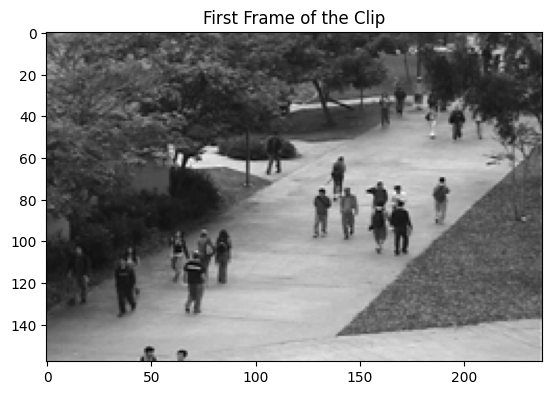

In [ ]:
#Load frames from the first training clip
clip_path = train_folders[0]
print(f"Clip path is {clip_path}")
frames = sorted(glob(os.path.join(clip_path, '*.tif')))

# Check if frames list is empty before accessing elements
if frames:
  # Display the first frame
  frame = cv2.imread(frames[0], cv2.IMREAD_GRAYSCALE)
  plt.imshow(frame, cmap='gray')
  plt.title("First Frame of the Clip")
  plt.show()
else:
  print(f"No .tif files found in the directory: {clip_path}")

### Play Video from one of the Train folders and one of the Test Folders *.tif and *.bmp files
Handle both tif and bmp files within the test folder

Playing training folder:
Playing image sequence from folder: /content/UCSD_Anomaly_Dataset/UCSDped1/Train/Train001


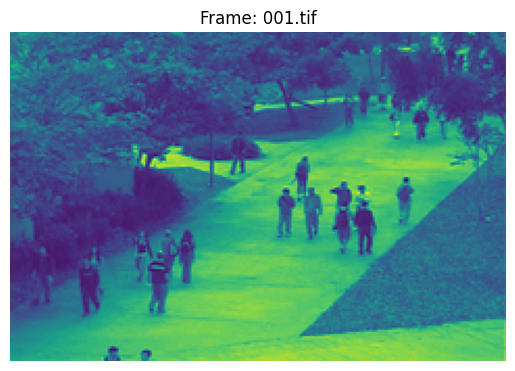

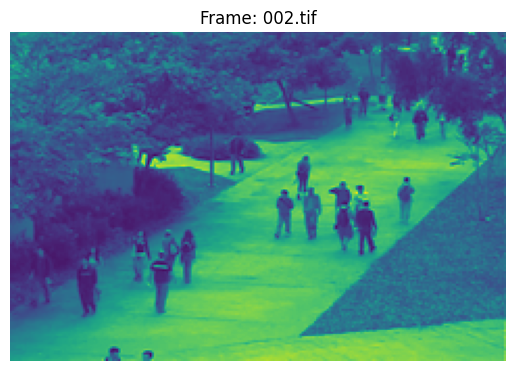

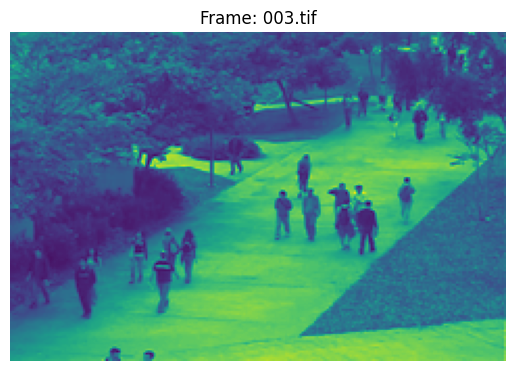

Playing testing folder:
Playing image sequence from folder: /content/UCSD_Anomaly_Dataset/UCSDped1/Test/Test005


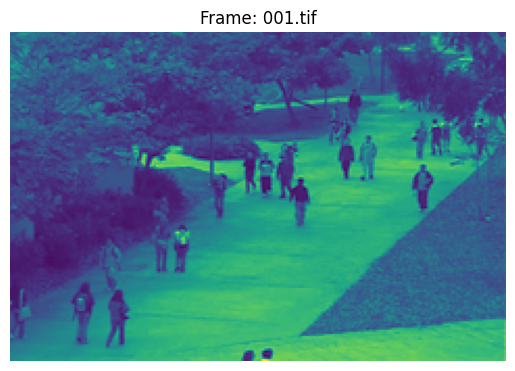

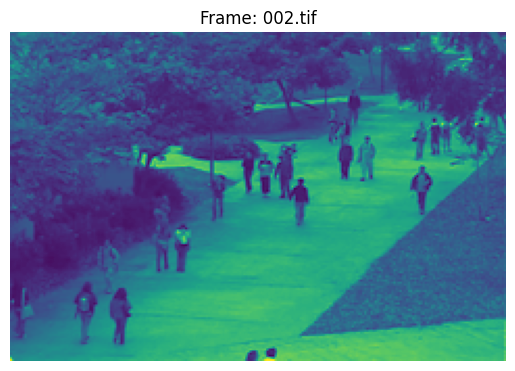

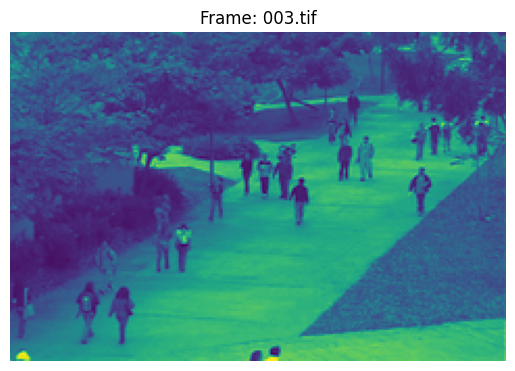

In [ ]:
def play_image_sequence(folder_path, extensions=("*.tif", "*.bmp", "*.png", "*.jpg")):
    """
    Function to play a sequence of image files (e.g., .tif, .bmp) in a folder.
    """
    # Collect all image files matching the specified extensions
    image_files = []
    for ext in extensions:
        image_files.extend(glob(os.path.join(folder_path, ext)))

    # Sort files to ensure correct playback order
    image_files = sorted(image_files)

    if not image_files:
        print(f"No image files found in folder: {folder_path}")
        return

    count = 0
    print(f"Playing image sequence from folder: {folder_path}")
    for img_file in image_files:
        # Read each image file
        frame = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)

        if frame is None:
            print(f"Error: Cannot read file {img_file}")
            continue

        # Display the frame
        plt.imshow(frame)
        plt.title(f"Frame: {os.path.basename(img_file)}")
        plt.axis('off')  # Hide axis ticks
        plt.show()
        #cv2_imshow(frame)

        count += 1
        if count >= 3: # Limit to 3 frames, don't play whole video
            break


    #cv2.destroyAllWindows()

# Play the first training folder and the first testing folder
if train_folders and test_folders:
    print("Playing training folder:")
    play_image_sequence(train_folders[0])  # Play images from the first training folder

    print("Playing testing folder:")
    play_image_sequence(test_folders[0])  # Play images from the first testing folder
else:
    print("Training or testing folders are empty.")

### Perform data augmentation

In [ ]:
# Augmentation function
def augment_frame(frame):
    frame = tf.image.random_flip_left_right(frame)
    frame = tf.image.random_brightness(frame, max_delta=0.2)
    frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2)
    return frame.numpy()  # Convert TensorFlow tensor back to a NumPy array for compatibility

### Preprocess the data

In [ ]:
def preprocess_videos(video_dir, frame_size=(64, 64), augment=False):
    video_paths = glob.glob(f"{video_dir}/**/*.tif", recursive=True)
    frames = []

    #for video_file in os.listdir(video_dir):
    for video_path in video_paths:

        # Use cv2.imread instead of cv2.VideoCapture
        frame = cv2.imread(video_path)
        if frame is None:
          print(f"cv2.imread() could not read the file in {video_path}.")

        # Resize and normalize
        frame = cv2.resize(frame, frame_size) / 255.0

        # Ensure 3 color channels (RGB) even if the original image is grayscale
        # If the input images are originally grayscale, make sure they have 3 color channels before resizing
        # Convert grayscale to RGB
        if len(frame.shape) == 2 or frame.shape[2] == 1:
          frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

        # Apply augmentation if enabled
        if augment:
          frame = augment_frame(frame)

        frames.append(frame)
        # cap.release()
    return np.array(frames)

### Pre-process training files

In [ ]:
import glob # Do not remove this to combine in general section, else code throws error

# Combine the training data paths
train_dirs = [
     os.path.join(ped1_path, 'Train'),
    os.path.join(ped2_path, 'Train')
]

# Preprocess the combined training data
train_frames = []
for train_dir in train_dirs:
    train_frames.extend(preprocess_videos(train_dir, frame_size=(128, 128), augment=True))
    print(f"Processed {train_dir}")

Processed /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train
Processed /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train


In [ ]:
# Save training frames
np.save("/content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/train_frames_augmented.npy", train_frames)

### Do not run the code below if preprocess_videos() has this line :   
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

In [ ]:
# Convert train_frames to a NumPy array if it's not already
train_frames = np.array(train_frames)

print("Shape of train_frames before fix:", train_frames.shape)

# Check if the last dimension (color channels) is 1 (grayscale)
if train_frames.shape[-1] == 1:
    # Convert grayscale to RGB by repeating the grayscale channel 3 times
    train_frames = np.repeat(train_frames, 3, axis=-1)

# OR if the color channels are missing
elif train_frames.shape[-1] != 3:
  # Convert grayscale to RGB using OpenCV (more robust)
  train_frames_rgb = []
  for frame in train_frames:
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
      train_frames_rgb.append(frame_rgb)

  train_frames = np.array(train_frames_rgb)

# Verify the shape after modification
print("Shape of train_frames after fix:", train_frames.shape)

In [ ]:
# Save training frames
np.save("/content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/train_frames_fixed.npy", train_frames)

### Pre-process Test files

In [ ]:
import glob
# Combine the testing data paths
test_dirs = [
 os.path.join(ped1_path, 'Test'),
    os.path.join(ped2_path, 'Test')
]

# Preprocess the combined testing data
test_frames = []
for test_dir in test_dirs:
    test_frames.extend(preprocess_videos(test_dir, frame_size=(128, 128), augment=True))
    print(f"Processed {test_dir}")

Processed /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test
Processed /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test


In [ ]:
# Save test frames
np.save("/content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/test_frames_augmented.npy", test_frames)

### Validate the processed data before training

In [ ]:
if np.any(np.isnan(train_frames)) or np.any(np.isinf(train_frames)):
    print("Data contains NaNs or Infs!")
    # Optionally, replace NaNs or Infs with zeros or another value
    train_frames = np.nan_to_num(train_frames, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
dataset_size = train_data.shape[0]
batch_size = 32

if dataset_size % batch_size != 0:
    print(f"Warning: Dataset size ({dataset_size}) is not divisible by batch size ({batch_size}).")


In [ ]:
# Normalize train_frames to [0, 1] range if not already normalized
train_frames = train_frames.astype('float32') / 255.0

In [ ]:
if np.any(train_frames == None):
    print("There are None values in train_frames!")


In [ ]:
for i, frame in enumerate(train_frames):
    if frame is None:
        print(f"None value found at index {i}")


In [ ]:
# Check and remove or replace None values:
train_frames = [frame for frame in train_frames if frame is not None]

# Check and fix NaNs or Infs:
if np.any(np.isnan(train_frames)) or np.any(np.isinf(train_frames)):
    print("Data contains NaNs or Infs!")
    # Optionally, replace NaNs or Infs with zeros or another value
    train_frames = np.nan_to_num(train_frames, nan=0.0, posinf=0.0, neginf=0.0)

# Ensure train_frames is a NumPy array
train_frames = np.array(train_frames, dtype=np.float32)

# Reshape to the correct dimensions for the model
train_frames = train_frames.reshape(-1, 128, 128, 3)


In [ ]:
print(train_frames.shape)

(9350, 128, 128, 3)


In [ ]:
train_frames = np.array(train_frames, dtype=np.float32)

### Define the Auto Encoder

### Auto Encoder with Bottleneck with ssim as loss function - Data augmentation not used for training.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanSquaredError

def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def build_autoencoder(input_shape):
    model = models.Sequential([
        # Encoder
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Down to 64x64x32
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Down to 32x32x64

        # Introduce bottleneck
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),  # Down to 16x16x128

        # Decoder
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Up to 32x32x128
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Up to 64x64x64
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Up to 128x128x32
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Match the original shape
    ])

    model.compile(optimizer='adam', loss=ssim_loss)
    #model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
input_shape = (128, 128, 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

### Encoder and Decoder using Loss function as MSE

In [ ]:
from tensorflow.keras import layers, models

def build_autoencoder(input_shape):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(encoder_input, decoded)
    return autoencoder

In [ ]:
# Build and compile the model
input_shape = (128, 128, 3)
autoencoder = build_autoencoder(input_shape)

from tensorflow.keras.optimizers import Adam

autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

### Callbacks for training

Warm up and decay learning scheduler

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr * 1.1  # Gradually increase for the first 5 epochs
    else:
        return lr * 0.9  # Gradually decrease afterwards

warmUpandDecayLearningScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)



ReduceLROnPlateau learning rate

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)




Save Model checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the checkpoint path
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv2_checkpoint_{epoch:02d}.keras"  # Changed extension to .keras

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',  # Save every epoch
    verbose=1,   # Print a message when saving
    monitor='val_loss',
    mode='min'
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

Debug callback

In [ ]:
class DebugCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: {logs}")

### Train the Auto Encoder

In [ ]:
from sklearn.model_selection import train_test_split

# Split train and validation data
train_data, val_data = train_test_split(train_frames, test_size=0.2, random_state=42)

train_data = train_data / 255.0
val_data = val_data / 255.0

# Check shapes
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

In [ ]:
# Check the shape of the training data
print(f"train_data shape: {train_data.shape}")
print(f"val_data shape: {val_data.shape}")

# Check model input shape
print(f"Model input shape: {autoencoder.input_shape}")


train_data shape: (7480, 128, 128, 3)
val_data shape: (1870, 128, 128, 3)
Model input shape: (None, 128, 128, 3)


In [ ]:
print(train_data.dtype)  # Should output: float32
print(val_data.dtype)    # Should output: float32

float32
float32


In [ ]:
print(np.isnan(train_data).any(), np.isnan(val_data).any())  # Should both be False


False False


In [ ]:
print(train_data is None, val_data is None)

False False


In [ ]:
# Check model summary
autoencoder.summary()

# Ensure input and output shapes match
assert autoencoder.input_shape[1:] == autoencoder.output_shape[1:], "Input and output shapes must match for autoencoders!"


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,994,379 (15.24 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,662,920 (10.16 MB)

### Train the model without any callbacks or learning rate scheduling

In [ ]:
# Train the model
history = autoencoder.fit(
    train_data,          # Input data
    train_data,          # Output data
    validation_data=(val_data, val_data),  # Validation inputs and outputs
    epochs=50,
    batch_size=8,
    callbacks=[DebugCallback()]
)

 #callbacks=[checkpoint_callback, early_stopping]
#autoencoder.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[warmUpandDecayLearningScheduler])

Train data shape: (7480, 128, 128, 3)
Validation data shape: (1870, 128, 128, 3)
Epoch 1/50
928/935 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1839e-06 - mae: 0.0016Epoch 1: {'loss': 3.206492465324118e-06, 'mae': 0.0015570694813504815, 'val_loss': 3.250165036661201e-06, 'val_mae': 0.0015667843399569392}
935/935 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 3.1840e-06 - mae: 0.0016 - val_loss: 3.2502e-06 - val_mae: 0.0016
Epoch 2/50
928/935 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1897e-06 - mae: 0.0016Epoch 2: {'loss': 3.206492465324118e-06, 'mae': 0.0015570704126730561, 'val_loss': 3.250165036661201e-06, 'val_mae': 0.0015667843399569392}
935/935 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 3.1898e-06 - mae: 0.0016 - val_loss: 3.2502e-06 - val_mae: 0.0016
Epoch 3/50
930/935 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2115e-06 - mae: 0.0016Epoch 3: {'loss': 3.206496103302925e-06, 'mae': 0.0015570701798424125, 'val_loss': 3.250165036661201e-06, 'val_mae': 0.0015667843399569392}
935/935 ━━━━━━━━

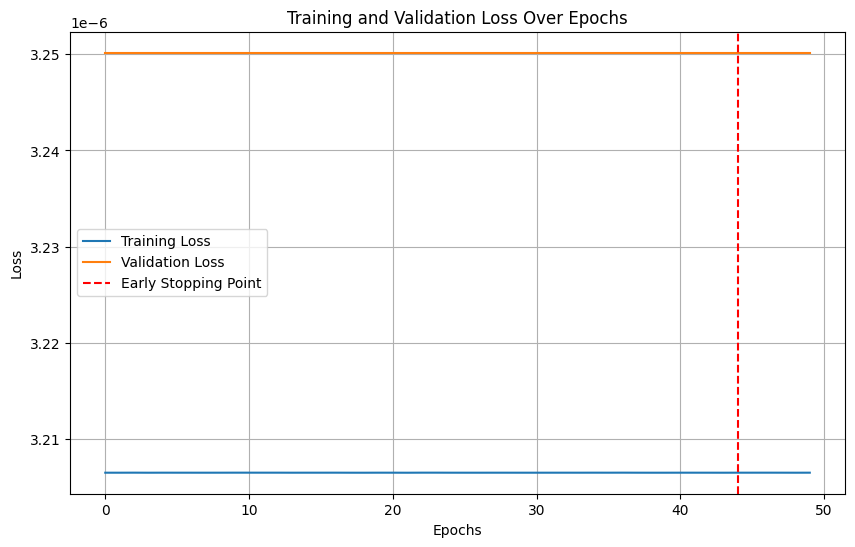

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(val_loss) - early_stopping.patience - 1, color='r', linestyle='--', label='Early Stopping Point')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Train the model using warm up and decay learning scheduler and early stopping.

In [ ]:
from sklearn.model_selection import train_test_split

# Split train and validation data
train_data, val_data = train_test_split(train_frames, test_size=0.2, random_state=42)

train_data = train_data / 255.0
val_data = val_data / 255.0

# Check shapes
print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

# Train the model
history = autoencoder.fit(
    train_data,          # Input data
    train_data,          # Output data
    validation_data=(val_data, val_data),  # Validation inputs and outputs
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint_callback, early_stopping, warmUpandDecayLearningScheduler]
)

Train data shape: (7480, 128, 128, 3)
Validation data shape: (1870, 128, 128, 3)
Epoch 1/50
931/935 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2045e-06 - mae: 0.0016
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv2_checkpoint_01.keras
935/935 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.2045e-06 - mae: 0.0016 - val_loss: 3.2502e-06 - val_mae: 0.0016 - learning_rate: 0.0011
Epoch 2/50
926/935 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1601e-06 - mae: 0.0015
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv2_checkpoint_02.keras
935/935 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 3.1606e-06 - mae: 0.0015 - val_loss: 3.2502e-06 - val_mae: 0.0016 - learning_rate: 0.0012
Epoch 3/50
929/935 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2000e-06 - mae: 0.0016
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv

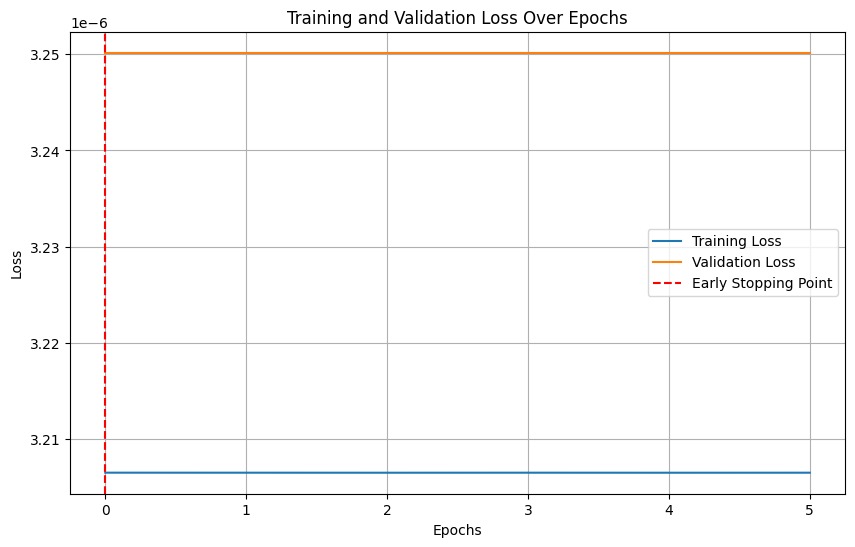

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(val_loss) - early_stopping.patience - 1, color='r', linestyle='--', label='Early Stopping Point')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
print(tf.__version__)  # Should show the installed TensorFlow version
print(tf.keras.__version__)  # Keras version should match TensorFlow


2.17.1
3.5.0


### Train the model without the learning rate scheduler to see difference.

In [ ]:
# Train the model and store the training history
history = autoencoder.fit(
    train_frames,
    train_frames,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0268
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv2_checkpoint_01.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0268 - val_loss: 0.0343
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv2_checkpoint_02.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0267 - val_loss: 0.0343
Epoch 3/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0268
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv2_checkpoint_03.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0268 - val_loss: 0.0343
Epoch 4/50
460/468 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0268
Epoch 4: saving model to /content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Proje

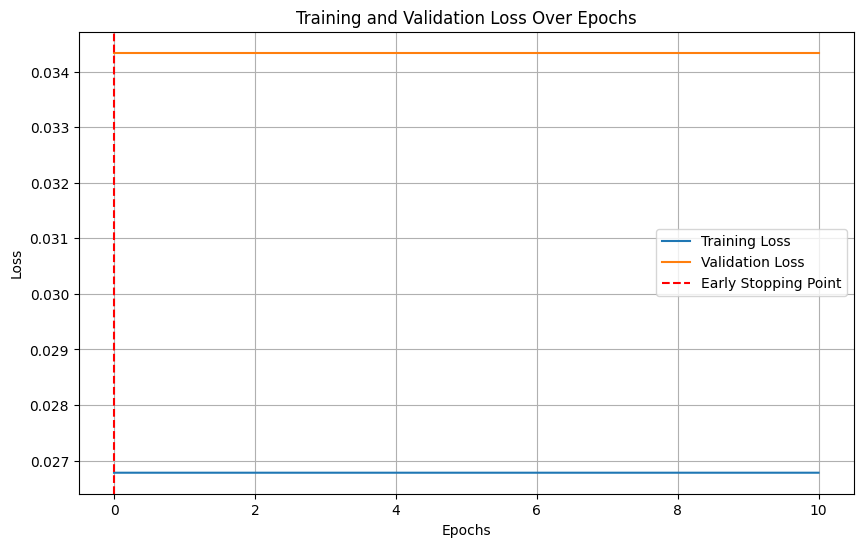

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(val_loss) - early_stopping.patience - 1, color='r', linestyle='--', label='Early Stopping Point')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The training loss dropped rapidly in the first epoch and plateaued, indicating fast initial learning.
The validation loss is stable and slightly higher than the training loss, indicating no overfitting.

### To be able to load from Saved Pre-processed data and resume training.

In [ ]:
import numpy as np

# Path to the saved NumPy file
saved_train_path = "/content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/train_frames_augmented.npy"

# Load the NumPy array
train_frames = np.load(saved_train_path)

# Verify the loaded data
#print("Loaded train_frames:", train_frames)
print("Shape of train_frames:", train_frames.shape)


Shape of train_frames: (9350, 128, 128, 3)


In [ ]:
import numpy as np

# Path to the saved NumPy file
saved_test_path = "/content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/test_frames_augmented.npy"

# Load the NumPy array
test_frames = np.load(saved_test_path)

# Verify the loaded data
#print("Loaded test_frames:", test_frames)
print("Shape of test_frames:", test_frames.shape)


Shape of test_frames: (9210, 128, 128, 3)


### To be able to load from saved checkpoint and resume training

In [ ]:
import tensorflow as tf

# Define the checkpoint path for the best model
saved_checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv2_checkpoint_06.keras"  # Replace 'XX' with the checkpoint epoch number

# Load the model from the checkpoint
autoencoder = tf.keras.models.load_model(saved_checkpoint_path)

print("Model loaded from checkpoint:", saved_checkpoint_path)

Model loaded from checkpoint: /content/drive/MyDrive/Colab Notebooks/AAI-521 Computer Vision/Final Project/autoencoderv2_checkpoint_06.keras


In [ ]:
# Compile the model again (necessary before training resumes)
model.compile(
    optimizer='adam',  # Use the same optimizer as before
    loss='mse',  # Use the same loss function
    metrics=['mae']
)

# Resume training
history = autoencoder.fit(
    train_frames,  # training data
    train_frames,  # training labels
    epochs=10,  # Number of additional epochs
    batch_size=32,
    validation_split=0.2
    callbacks=[checkpoint_callback],  # Continue saving checkpoints
    verbose=1
)

### Anomaly Detection and Testing  / Model Evaluation Metrics.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

585/585 ━━━━━━━━━━━━━━━━━━━━ 255s 435ms/step
576/576 ━━━━━━━━━━━━━━━━━━━━ 244s 424ms/step


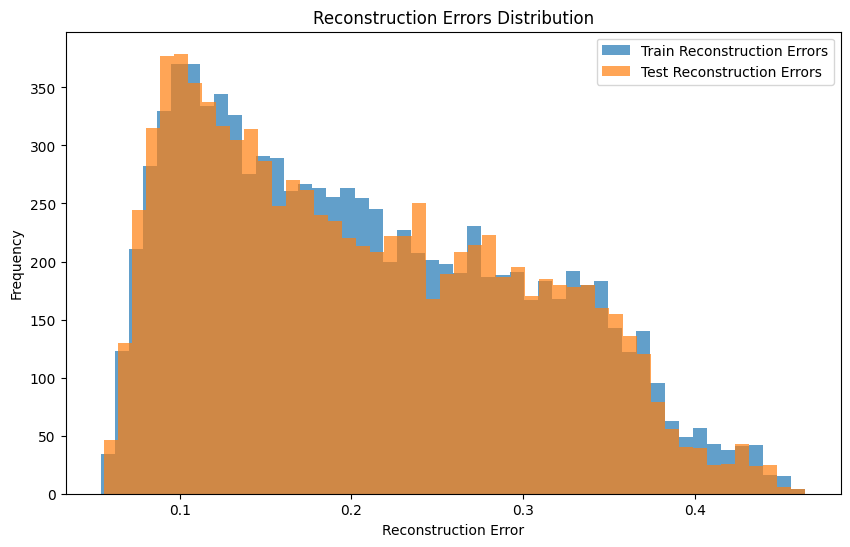

In [ ]:
# Function to compute reconstruction error
def compute_reconstruction_error(model, data):
    """
    Compute the reconstruction error for a dataset.

    Args:
        model: The trained autoencoder model.
        data: The dataset (train or test) as a NumPy array of shape (n_samples, height, width, channels).

    Returns:
        reconstruction_errors: A list of reconstruction errors for each frame.
    """
    reconstructed_data = model.predict(data, batch_size=16)
    reconstruction_errors = np.mean((data - reconstructed_data) ** 2, axis=(1, 2, 3))
    return reconstruction_errors

# Compute reconstruction errors for training and test frames
train_reconstruction_errors = compute_reconstruction_error(autoencoder, train_frames)
test_reconstruction_errors = compute_reconstruction_error(autoencoder, test_frames)

# Visualize reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(train_reconstruction_errors, bins=50, alpha=0.7, label="Train Reconstruction Errors")
plt.hist(test_reconstruction_errors, bins=50, alpha=0.7, label="Test Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Reconstruction Errors Distribution")
plt.show()

Ground-Truth Data:

The gt_data list holds the anomaly frame ranges for each test video as Python ranges.
It’s used to mark the corresponding frames as anomalies (1) in the labels array.

Exclude Certain Videos:

The exclude_gt_indices parameter ensures that specific ground-truth indices are excluded (e.g., test003 corresponds to index 2 in a 0-based index).

Read Frame Counts:
The code calculates the total number of frames in each video by counting .tif files in the corresponding folder.

Populate test_labels:
A dictionary maps video folder names (e.g., test001) to their respective labels.

Outputs:
Verify the shape of labels for each video to ensure correctness.

In [ ]:
# Evaluate anomaly detection using a threshold
threshold = np.percentile(train_reconstruction_errors, 95)  # 95th percentile of train errors
print(f"Threshold for anomaly detection: {threshold}")

Threshold for anomaly detection: 0.3739907064620348


### Process the matlab files to extract the ground truth information for the anomalous frames in the test data.

In [ ]:
import os
import numpy as np

def generate_test_labels(ped1_test_path, gt_data, exclude_gt_indices):
    """
    Generate test labels for UCSDped1 dataset.

    Args:
        ped1_test_path (str): Path to the Test folder (e.g., UCSDped1/Test/).
        gt_data (list of lists): Ground truth frame ranges for each video.
        exclude_gt_indices (list): Indices of ground truth to exclude (0-based index).

    Returns:
        dict: A dictionary mapping video names to their respective test labels.
    """
    test_labels = {}

    # Get valid folders: Filter out files and exclude folders with '_gt'
    test_folders = sorted(
        [folder for folder in os.listdir(ped1_test_path)
         if folder.startswith('Test') and os.path.isdir(os.path.join(ped1_test_path, folder)) and '_gt' not in folder]
    )

    # Debug: Print the number of folders and ground truth entries
    print(f"Number of test folders: {len(test_folders)}")
    print(f"Number of ground truth entries: {len(gt_data)}")

    # Limit processing to the length of ground truth data
    for video_index, folder in enumerate(test_folders[:len(gt_data)]):  # Avoid index out of range
        if video_index in exclude_gt_indices:
            continue  # Skip excluded indices

        folder_path = os.path.join(ped1_test_path, folder)
        if not os.path.exists(folder_path):
            print(f"Folder not found: {folder_path}")
            continue

        # Determine total frames in the video
        total_frames = len([f for f in os.listdir(folder_path) if f.endswith('.tif')])

        # Initialize all frames as normal (0)
        labels = np.zeros(total_frames, dtype=int)

        # Get the anomaly frame ranges for this video
        anomaly_frames = gt_data[video_index]

        # Clip anomaly frames to fit within the total_frames range
        anomaly_frames = [frame for frame in anomaly_frames if frame < total_frames]

        # Mark anomalies as 1
        labels[anomaly_frames] = 1

        # Store the labels for the video
        test_labels[folder] = labels

    return test_labels


ped1_test_path = os.path.join(ped1_path, 'Test')

#ped1_test_path = "/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
gt_data = [
    list(range(60, 153)), list(range(50, 176)), list(range(91, 201)), list(range(31, 169)),
    list(range(5, 91)) + list(range(140, 201)), list(range(1, 101)) + list(range(110, 201)),
    list(range(1, 176)), list(range(1, 95)), list(range(1, 49)), list(range(1, 141)),
    list(range(70, 166)), list(range(130, 201)), list(range(1, 157)), list(range(1, 201)),
    list(range(138, 201)), list(range(123, 201)), list(range(1, 48)), list(range(54, 121)),
    list(range(64, 139)), list(range(45, 176)), list(range(31, 201)), list(range(16, 108)),
    list(range(8, 166)), list(range(50, 172)), list(range(40, 136)), list(range(77, 145)),
    list(range(10, 123)), list(range(105, 201)), list(range(1, 16)) + list(range(45, 114)),
    list(range(175, 201)), list(range(1, 181)), list(range(1, 53)) + list(range(65, 116)),
    list(range(5, 166)), list(range(1, 122)), list(range(86, 201)), list(range(15, 109))
]
exclude_gt_indices = [2, 3, 13, 17, 18, 20, 21, 22, 23, 31]  # Indices to exclude

test_labels_dict_ped1  = generate_test_labels(ped1_test_path, gt_data, exclude_gt_indices)

# Verify
for video, labels in test_labels_dict_ped1.items():
    print(f"{video}: {labels.shape} labels")


Number of test folders: 36
Number of ground truth entries: 36
Test001: (200,) labels
Test002: (200,) labels
Test005: (200,) labels
Test006: (200,) labels
Test007: (200,) labels
Test008: (200,) labels
Test009: (200,) labels
Test010: (200,) labels
Test011: (200,) labels
Test012: (200,) labels
Test013: (200,) labels
Test015: (200,) labels
Test016: (200,) labels
Test017: (200,) labels
Test020: (200,) labels
Test025: (200,) labels
Test026: (200,) labels
Test027: (200,) labels
Test028: (200,) labels
Test029: (200,) labels
Test030: (200,) labels
Test031: (200,) labels
Test033: (200,) labels
Test034: (200,) labels
Test035: (200,) labels
Test036: (200,) labels


In [ ]:
import os
import numpy as np

def generate_test_labels(ped_test_path, gt_data, exclude_gt_indices):
    """
    Generate test labels for UCSD pedestrian anomaly datasets (Ped1 and Ped2).

    Args:
        ped_test_path (str): Path to the Test folder (e.g., UCSDped1/Test/ or UCSDped2/Test/).
        gt_data (list of lists): Ground truth frame ranges for each video.
        exclude_gt_indices (list): Indices of ground truth to exclude (0-based index).

    Returns:
        dict: A dictionary mapping video names to their respective test labels.
    """
    test_labels = {}

    # Get valid folders: Filter out files, folders with '_gt' and exclude ground truth folder names
    test_folders = sorted(
        [folder for folder in os.listdir(ped_test_path)
         if folder.startswith('Test') and os.path.isdir(os.path.join(ped_test_path, folder)) and '_gt' not in folder]
    )

    # Debug: Print the number of folders and ground truth entries
    print(f"Number of test folders: {len(test_folders)}")
    print(f"Number of ground truth entries: {len(gt_data)}")

    # Limit processing to the length of ground truth data
    for video_index, folder in enumerate(test_folders[:len(gt_data)]):  # Avoid index out of range
        if video_index in exclude_gt_indices:
            continue  # Skip excluded indices

        folder_path = os.path.join(ped_test_path, folder)
        if not os.path.exists(folder_path):
            print(f"Folder not found: {folder_path}")
            continue

        # Determine total frames in the video
        total_frames = len([f for f in os.listdir(folder_path) if f.endswith('.tif')])

        # Initialize all frames as normal (0)
        labels = np.zeros(total_frames, dtype=int)

        # Get the anomaly frame ranges for this video
        anomaly_frames = gt_data[video_index]

        # Clip anomaly frames to fit within the total_frames range
        anomaly_frames = [frame for frame in anomaly_frames if frame < total_frames]

        # Mark anomalies as 1
        labels[anomaly_frames] = 1

        # Store the labels for the video
        test_labels[folder] = labels

    return test_labels


ped2_test_path = os.path.join(ped2_path, 'Test')
#ped2_test_path = "/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test"
gt_data_ped2 = [
    list(range(61, 180)), list(range(92, 190)), list(range(31, 168)), list(range(49, 174)),
    list(range(45, 140)), list(range(151, 180)), list(range(1, 129)), list(range(60, 165)),
    list(range(1, 120)), list(range(30, 139)), list(range(25, 151)), list(range(71, 180))
]
exclude_gt_indices_ped2 = []  # No exclusions for UCSDPed2 by default

test_labels_dict_ped2 = generate_test_labels(ped2_test_path, gt_data_ped2, exclude_gt_indices_ped2)

# Verify
for video, labels in test_labels_dict_ped2.items():
    print(f"{video}: {labels.shape} labels")


Number of test folders: 12
Number of ground truth entries: 12
Test001: (180,) labels
Test002: (180,) labels
Test003: (150,) labels
Test004: (180,) labels
Test005: (150,) labels
Test006: (180,) labels
Test007: (180,) labels
Test008: (180,) labels
Test009: (120,) labels
Test010: (150,) labels
Test011: (180,) labels
Test012: (180,) labels


In [ ]:
print(f"Number of test folders: {len(test_folders)}")
print(f"Number of ground truth entries: {len(gt_data)}")


Number of test folders: 70
Number of ground truth entries: 36


### ROC-AUC Score

In [ ]:
# Classify test frames as normal (0) or anomalous (1) based on reconstruction errors and threshold
test_predictions = test_reconstruction_errors > threshold

# Let's merge the labels from both datasets
test_labels = []

# UCSDped1 ground truth labels
for video in test_labels_dict_ped1:
    test_labels.extend(test_labels_dict_ped1[video])

# UCSDped2 ground truth labels
for video in test_labels_dict_ped2:
    test_labels.extend(test_labels_dict_ped2[video])

# Convert to numpy array
test_labels = np.array(test_labels)

# Calculate reconstruction errors for UCSDped1: reconstruction_errors_ped1
# Calculate reconstruction errors for UCSDped2: reconstruction_errors_ped2
# test_reconstruction_errors = np.concatenate([reconstruction_errors_ped1, reconstruction_errors_ped2])

# Ensure consistent length between test_labels and test_reconstruction_errors
if len(test_labels) != len(test_reconstruction_errors):
    min_length = min(len(test_labels), len(test_reconstruction_errors))
    test_labels = test_labels[:min_length]
    test_reconstruction_errors = test_reconstruction_errors[:min_length]

# Calculate ROC-AUC
roc_auc = roc_auc_score(test_labels, test_reconstruction_errors)
print(f"ROC-AUC Score: {roc_auc}")


ROC-AUC Score: 0.509743092295289


### Visualize Anomalous frames

In [ ]:
# Visualize some anomalies and normal reconstructions
def plot_reconstruction(original, reconstructed, error, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Reconstructed")
    plt.imshow(reconstructed)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Error (MSE: {error:.4f})")
    plt.imshow(np.abs(original - reconstructed))
    plt.axis("off")

    plt.suptitle(title)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


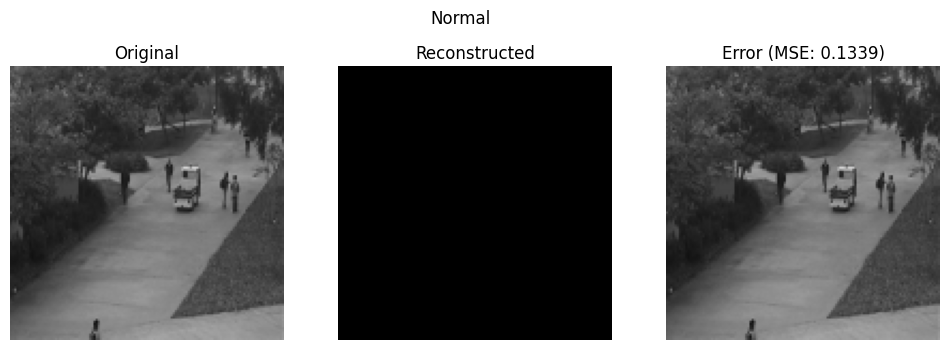

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


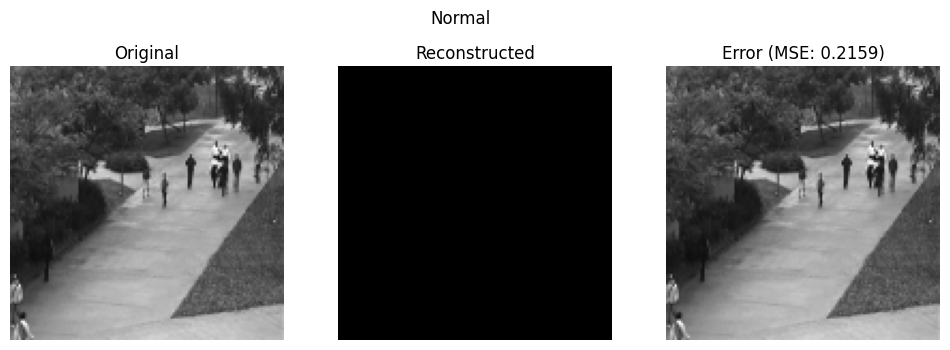

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


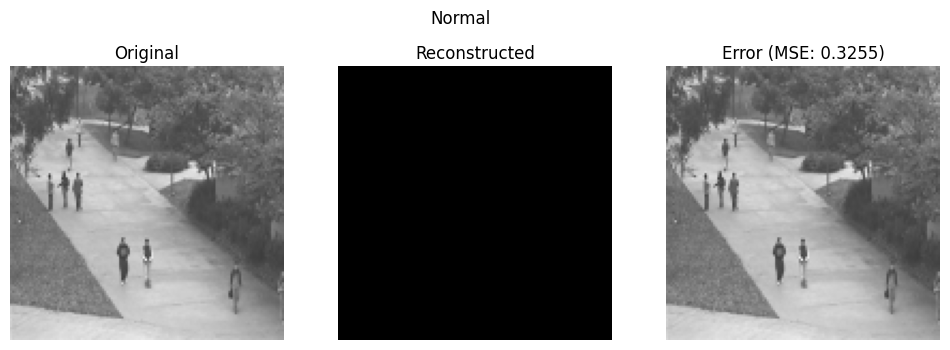

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


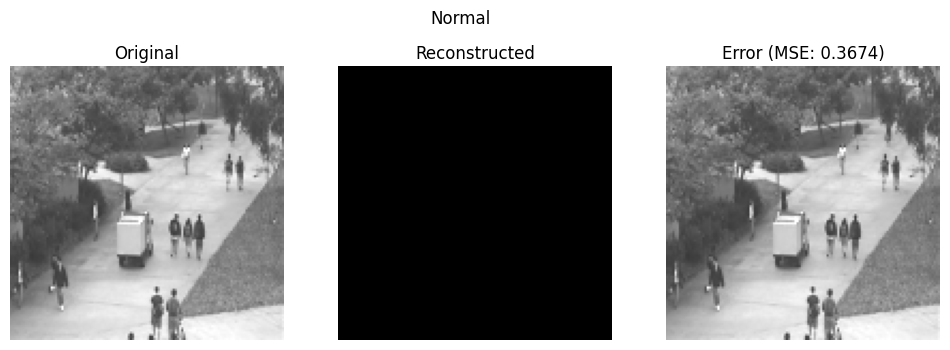

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


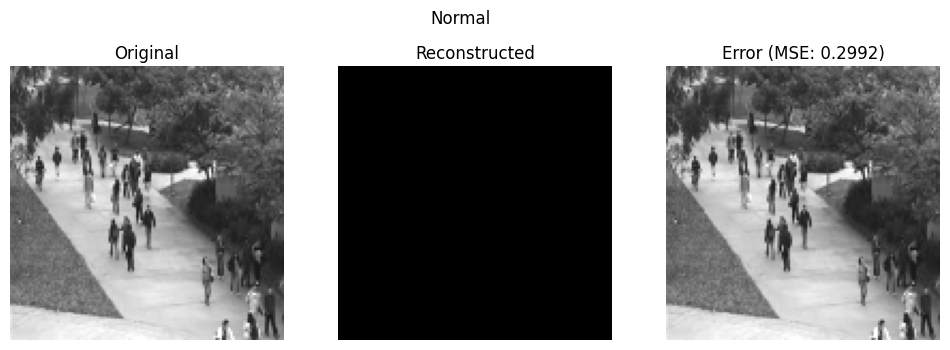

In [ ]:
# Ensure indices are sampled within the bounds of both arrays
common_length = min(len(test_frames), len(test_reconstruction_errors))

# Visualize some anomlaous frames
for i in range(5):
    idx = np.random.choice(common_length)  # Use the minimum length
    original = test_frames[idx]
    reconstructed = autoencoder.predict(np.expand_dims(original, axis=0))[0]
    error = test_reconstruction_errors[idx]
    title = "Anomalous" if test_predictions[idx] else "Normal"
    plot_reconstruction(original, reconstructed, error, title)

In [ ]:
import matplotlib.pyplot as plt

def display_anomalous_frames_with_ground_truth(test_frames, test_predictions, test_labels, num_samples=5):
    """
    Displays anomalous frames along with their corresponding ground truth labels.

    Args:
        test_frames (numpy.ndarray): Array of test frames (e.g., images or features).
        test_predictions (numpy.ndarray): Array of model predictions (1 for anomaly, 0 for normal).
        test_labels (numpy.ndarray): Array of ground truth labels (1 for anomaly, 0 for normal).
        num_samples (int): Number of samples to display.
    """
    # Identify indices where predictions and ground truth indicate anomalies
    anomaly_indices = [i for i, (pred, label) in enumerate(zip(test_predictions, test_labels)) if pred == 1 or label == 1]

    if not anomaly_indices:
        print("No anomalies detected to display.")
        return

    # Randomly select a subset of anomaly indices to display
    selected_indices = np.random.choice(anomaly_indices, size=min(num_samples, len(anomaly_indices)), replace=False)

    for idx in selected_indices:
        # Extract frame, prediction, and ground truth
        frame = test_frames[idx]
        prediction = test_predictions[idx]
        ground_truth = test_labels[idx]

        # Plot the frame
        plt.figure(figsize=(6, 6))
        plt.imshow(frame, cmap='gray')  # Adjust `cmap` if frames are not grayscale
        title = f"Frame Index: {idx}\nPrediction: {'Anomalous' if prediction else 'Normal'}\nGround Truth: {'Anomalous' if ground_truth else 'Normal'}"
        plt.title(title)
        plt.axis("off")
        plt.show()


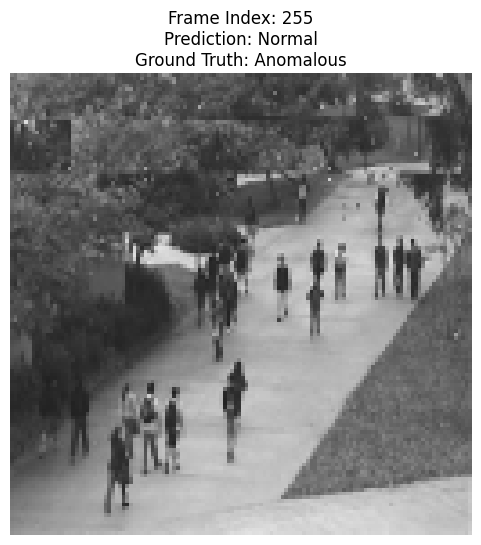

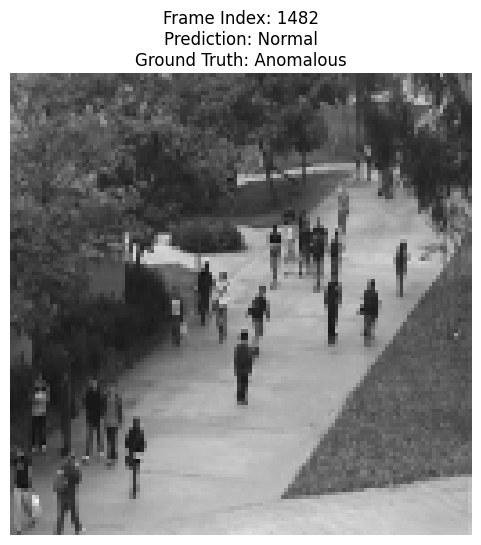

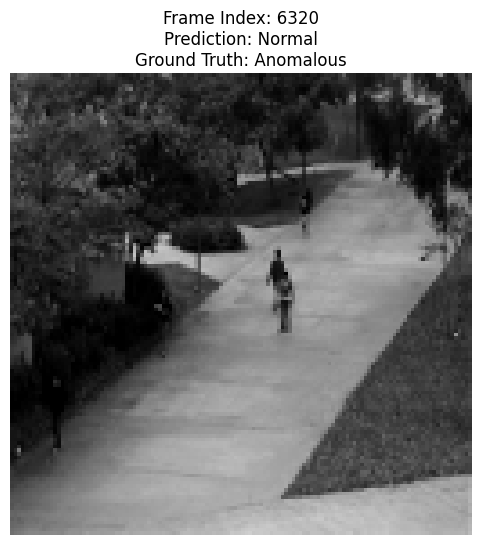

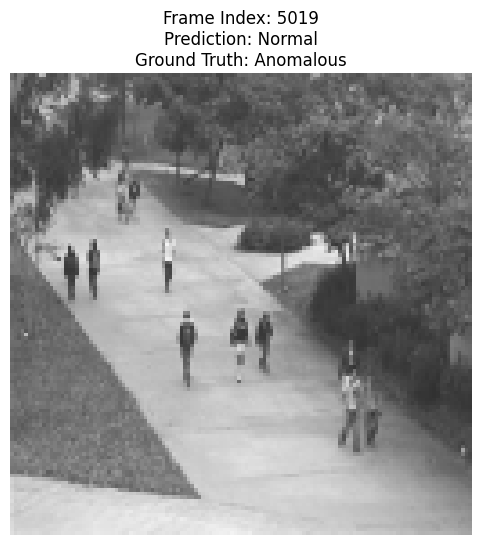

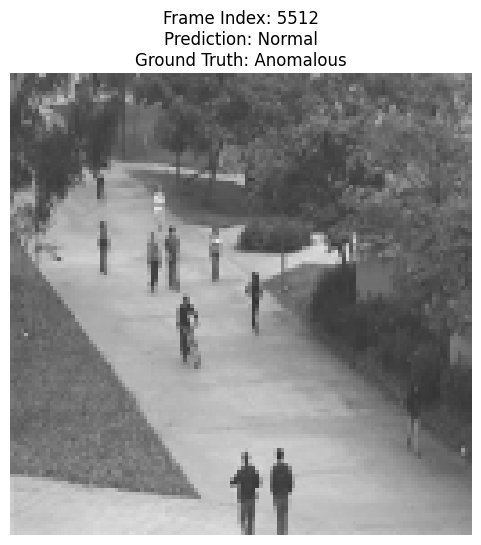

In [ ]:
# Display 5 anomalous frames with their ground truths
display_anomalous_frames_with_ground_truth(test_frames, test_predictions, test_labels, num_samples=5)


### Evaluate the performance of the model

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score

def print_classification_metrics(test_predictions, test_labels):
    """
    Calculate and print classification metrics: F1 Score, Recall, and Accuracy.

    Args:
        test_predictions (numpy.ndarray): Array of model predictions (1 for anomaly, 0 for normal).
        test_labels (numpy.ndarray): Array of ground truth labels (1 for anomaly, 0 for normal).
    """
    # Calculate metrics
    f1 = f1_score(test_labels, test_predictions)
    recall = recall_score(test_labels, test_predictions)
    accuracy = accuracy_score(test_labels, test_predictions)

    # Print metrics
    print(f"Classification Metrics:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

print_classification_metrics(test_predictions, test_labels)


Classification Metrics:
F1 Score: 0.0245
Recall: 0.0125
Accuracy: 0.4363


## Model 2: Pretrained Convolutional Autoencoder (CAE) + ConvLSTM

The goal of this model was to attempt to build on the limitations of the autoencoder (Model 1) by incorporating temporal analysis, allowing it to detect patterns across sequences rather than frame-by-frame.

It uses a pre-trained ResNet50 backbone to extract spatial features for the encoder, while the ConvLSTM layer captures temporal dependencies, such as motion and behavior over time. Finally the decoder, rather than reconstructing frames, (like M1) outputs a binary anomaly score for each frame, indicating whether the frame is normal or anomalous based on the learned patterns.

The thinking here was that by looking at sequential data it could perhaps better identify dynamic irregularities, such as bikes or cars which tend to wind through crowds and move faster through the frames.



In [193]:
# Parameters
FRAME_SIZE = (158, 238)
BATCH_SIZE = 16
SEQUENCE_LENGTH = 10
input_shape = (FRAME_SIZE[0], FRAME_SIZE[1], 3)  # (Height, Width, Channels)

# Recalculate feature shape for the temporal model
feature_shape = (input_shape[0] // 32, input_shape[1] // 32, 64)  # Adjust for spatial reduction

### Encoder

In [35]:
def build_encoder(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pretrained layers

    # Encoder model
    encoder = models.Sequential([
        base_model,
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Keep spatial info
        layers.MaxPooling2D((2, 2), strides=(2, 2)),  # Reduce spatial dimensions
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add another conv layer
        layers.UpSampling2D((2, 2))  # Slightly upsample to adjust spatial mismatch
    ])
    return encoder

# Build and summarize the encoder
encoder = build_encoder(input_shape)
encoder.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 5, 8, 64)            │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 2, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_12 (UpSampling2D)      │ (None, 4, 8, 64)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,804,352 (94.62 MB)

 Trainable params: 1,216,640 (4.64 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Decoder

In [36]:
def build_decoder(latent_shape):
    decoder = models.Sequential([
        layers.Input(shape=latent_shape),
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Upsample to (8, 16)
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Upsample to (16, 32)
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((10, 8)),  # Upsample to (160, 256)
        layers.Cropping2D(((1, 1), (9, 9))),  # Crop to (158, 238)
        layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')  # Reconstruct final frame
    ])
    return decoder

decoder = build_decoder(latent_shape=(4, 8, 64))
decoder.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_12                  │ (None, 4, 8, 128)           │          73,856 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_13 (UpSampling2D)      │ (None, 8, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 8, 16, 64)           │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 16, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 16, 32, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_15 (UpSampling2D)      │ (None, 160, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 158, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 158, 238, 3)         │             867 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,979 (652.26 KB)

 Trainable params: 166,979 (652.26 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Test the encoder within TimeDistributed
dummy_sequence = tf.random.normal((1, 10, 158, 238, 3))  # Simulate a batch with 10 frames
encoded_sequence = layers.TimeDistributed(encoder)(dummy_sequence)
print(f"Encoded sequence shape: {encoded_sequence.shape}")

# Test the decoder within TimeDistributed
decoded_sequence = layers.TimeDistributed(decoder)(encoded_sequence)
print(f"Decoded sequence shape: {decoded_sequence.shape}")

Encoded sequence shape: (1, 10, 4, 8, 64)
Decoded sequence shape: (1, 10, 158, 238, 3)


### Temporal/LSTM Model

In [38]:
def build_temporal_model(sequence_length, latent_shape):
    model = models.Sequential([
        # Temporal modeling with ConvLSTM2D
        layers.ConvLSTM2D(64, (3, 3), activation='relu', padding='same', return_sequences=True,
                          input_shape=(sequence_length, *latent_shape)),
        layers.ConvLSTM2D(32, (3, 3), activation='relu', padding='same', return_sequences=True),  # Keep return_sequences=True

        # Spatial anomaly scoring with Conv2D
        layers.TimeDistributed(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')),  # Score for each frame

        # Average spatial anomaly scores for each frame
        layers.TimeDistributed(layers.GlobalAveragePooling2D())  # Score per frame
    ])
    return model

# Adjust latent_shape to match encoder's output
latent_shape = (4, 8, 64)  # Match the output from the encoder
temporal_model = build_temporal_model(SEQUENCE_LENGTH, latent_shape)
temporal_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_14 (ConvLSTM2D)          │ (None, 10, 4, 8, 64)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_15 (ConvLSTM2D)          │ (None, 10, 4, 8, 32)        │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, 10, 4, 8, 1)         │             289 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, 10, 1)               │               0 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,177 (1.55 MB)

 Trainable params: 406,177 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Combining the Encoder with the LSTM

In [39]:
def build_combined_model(encoder, decoder, temporal_model, sequence_length):
    inputs = layers.Input(shape=(sequence_length, 158, 238, 3))  # Original frame dimensions

    # Apply encoder to compress frames
    encoded_frames = layers.TimeDistributed(encoder)(inputs)  # Shape: (None, 10, 40, 60, 64)

    # Apply temporal model to detect anomalies in encoded frames
    temporal_scores = temporal_model(encoded_frames)  # Shape: (None, 10, 40, 60, 1)

    # Decode frames for reconstruction (if needed)
    reconstructed_frames = layers.TimeDistributed(decoder)(encoded_frames)  # Shape: (None, 10, 158, 238, 3)

    # Define the model
    model = Model(inputs, temporal_scores)
    return model


# Compile the combined model
combined_model = build_combined_model(encoder, decoder, temporal_model, SEQUENCE_LENGTH)
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
combined_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)          │ (None, 10, 158, 238, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, 10, 4, 8, 64)        │      24,804,352 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 10, 1)               │         406,177 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,210,529 (96.17 MB)

 Trainable params: 1,622,817 (6.19 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Sequence Generators

These helped prepare our data to work effectively with the ConvLSTM model.

*MultiDatasetSequenceGenerator* handled loading and preprocessing training data by organizing frames from multiple datasets into manageable sequences, resizing them to the target dimensions, and normalizing the pixel values for consistency/ease of training.

*TestSequenceGenerator* handled loading and preprocessing test and validation data, by dividing each video sequence nto smaller frame sequences and resized to the target dimensions. It also converted pixel-level anomaly masks into frame-level binary labels, aligning with the ConvLSTM model's output, which focused on detecting anomalies on a per-frame basis.

#### MultiDatasetSequenceGenerator

In [24]:
class MultiDatasetSequenceGenerator(Sequence):
    def __init__(self, base_paths, sequence_length, batch_size, frame_size):
        self.base_paths = base_paths  # List of dataset paths
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.frame_size = frame_size

        # Collect all frame paths from each dataset
        self.frame_paths = self._get_frame_paths()

    def _get_frame_paths(self):
        frame_paths = []
        for base_path in self.base_paths:
            video_folders = sorted([os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])
            for folder in video_folders:
                tif_files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')])
                frame_paths.extend(tif_files)
        return frame_paths

    def __len__(self):
        return len(self.frame_paths) // (self.batch_size * self.sequence_length)

    def __getitem__(self, idx):
        batch_frames = []
        for i in range(self.batch_size):
            start_idx = (idx * self.batch_size + i) * self.sequence_length
            sequence = []
            for j in range(self.sequence_length):
                frame = cv2.imread(self.frame_paths[start_idx + j], cv2.IMREAD_COLOR)
                # Ensure resizing uses (width, height)
                frame = cv2.resize(frame, (self.frame_size[1], self.frame_size[0]))  # (width, height)
                frame = frame / 255.0  # Normalize
                sequence.append(frame)
            batch_frames.append(sequence)
        return np.array(batch_frames), np.zeros((self.batch_size, self.sequence_length))  # Labels as zeros for training

#### Test Generator

In [25]:
class TestSequenceGenerator(Sequence):
    def __init__(self, base_path, sequence_length, batch_size, frame_size):
        self.base_path = base_path
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.frame_size = frame_size  # (height, width)

        # List all video folders (excluding *_gt folders)
        self.video_folders = sorted(
            [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f)) and not f.endswith("_gt")]
        )

        self.frame_paths = self._get_frame_paths()
        self.gt_paths = self._get_gt_paths()

        # Check mismatch between frame_paths and gt_paths
        if len(self.frame_paths) != len(self.gt_paths):
            print(f"Warning: Mismatch between frame paths ({len(self.frame_paths)}) and GT paths ({len(self.gt_paths)})")
            min_len = min(len(self.frame_paths), len(self.gt_paths))
            self.frame_paths = self.frame_paths[:min_len]
            self.gt_paths = self.gt_paths[:min_len]

    def _get_frame_paths(self):
        frame_paths = []
        for folder in self.video_folders:
            tif_files = sorted(
                [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')]
            )
            frame_paths.extend(tif_files)
        return frame_paths

    def _get_gt_paths(self):
        gt_paths = []
        for folder in self.video_folders:
            gt_folder = folder + "_gt"  # Append "_gt" to each video folder name
            if os.path.exists(gt_folder):
                bmp_files = sorted(
                    [os.path.join(gt_folder, f) for f in os.listdir(gt_folder) if f.endswith('.bmp')]
                )
                gt_paths.extend(bmp_files)
            else:
                print(f"Warning: GT folder not found for {folder}")
        return gt_paths

    def __len__(self):
        return len(self.frame_paths) // (self.batch_size * self.sequence_length)

    def __getitem__(self, idx):
        batch_frames = []
        batch_labels = []
        for i in range(self.batch_size):
            start_idx = (idx * self.batch_size + i) * self.sequence_length
            sequence = []
            labels = []
            for j in range(self.sequence_length):
                frame_path = self.frame_paths[start_idx + j]
                frame = cv2.imread(frame_path, cv2.IMREAD_COLOR)
                frame = cv2.resize(frame, (self.frame_size[1], self.frame_size[0])) / 255.0  # Normalize frame

                # Handle missing GT masks
                if start_idx + j < len(self.gt_paths):
                    gt_mask_path = self.gt_paths[start_idx + j]
                    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
                    labels.append(1 if gt_mask.max() > 0 else 0)
                else:
                    # set to normal/0 if no GT mask exists
                    labels.append(0)

                sequence.append(frame)
            batch_frames.append(sequence)
            batch_labels.append(labels)
        return np.array(batch_frames), np.array(batch_labels)

### Parameters and Training

In [32]:
# Create the generator for training data (UCSDped1 + UCSDped2 train sets)
train_generator = MultiDatasetSequenceGenerator(
    base_paths=[
        '/content/UCSD_Anomaly_Dataset/UCSDped1/Train',
        '/content/UCSD_Anomaly_Dataset/UCSDped2/Train'
    ],
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
    frame_size=FRAME_SIZE
)

# Test the training generator
sample_batch, _ = train_generator[0]
print(f"Training Batch shape: {sample_batch.shape}")  # Should be (batch_size, sequence_length, FRAME_SIZE[0], FRAME_SIZE[1], 3)

Training Batch shape: (16, 10, 158, 238, 3)


In [27]:
# Create the generator for validation data (UCSDped1 test set)
val_generator = TestSequenceGenerator(
    base_path='/content/UCSD_Anomaly_Dataset/UCSDped1/Test',
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
    frame_size=FRAME_SIZE
)

# Test the validation generator
val_batch, val_labels = val_generator[0]
print(f"Validation Batch shape: {val_batch.shape}")  # Should be (batch_size, sequence_length, FRAME_SIZE[0], FRAME_SIZE[1], 3)
print(f"Validation Labels shape: {val_labels.shape}")  # Should be (batch_size, sequence_length)

sample_batch, _ = val_generator[0]
print(f"Val Batch shape: {sample_batch.shape}")  # Should be (batch_size, sequence_length, FRAME_SIZE[0], FRAME_SIZE[1], 3)

Validation Batch shape: (16, 10, 158, 238, 3)
Validation Labels shape: (16, 10)
Val Batch shape: (16, 10, 158, 238, 3)


In [34]:
train_batch, train_labels = next(iter(train_generator))
print(f"Train batch shape: {train_batch.shape}")
print(f"Train labels shape: {train_labels.shape}")

val_batch, val_labels = next(iter(val_generator))
print(f"Validation batch shape: {val_batch.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Train batch shape: (16, 10, 158, 238, 3)
Train labels shape: (16, 10)
Validation batch shape: (16, 10, 158, 238, 3)
Validation labels shape: (16, 10)


In [43]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# class DebugCallback(tf.keras.callbacks.Callback):
#     def on_train_batch_begin(self, batch, logs=None):
#         print(f"Batch {batch} started.")
#     def on_train_batch_end(self, batch, logs=None):
#         print(f"Batch {batch} ended. Logs: {logs}")

callbacks = [early_stopping, reduce_lr]#, DebugCallback()]

try:
    combined_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        verbose=1,
        callbacks=callbacks
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 408s 7s/step - accuracy: 1.0000 - loss: 2.7467e-04 - val_accuracy: 0.3568 - val_loss: 0.6428 - learning_rate: 0.0010
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 387s 7s/step - accuracy: 1.0000 - loss: 4.9153e-06 - val_accuracy: 0.3568 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 385s 7s/step - accuracy: 1.0000 - loss: 2.3348e-11 - val_accuracy: 0.3568 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 385s 7s/step - accuracy: 1.0000 - loss: 2.2476e-11 - val_accuracy: 0.3568 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 1.0000 - loss: 2.3292e-11 - val_accuracy: 0.3568 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6

#### Sanity check Validation

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
Predictions shape: (16, 10, 1)


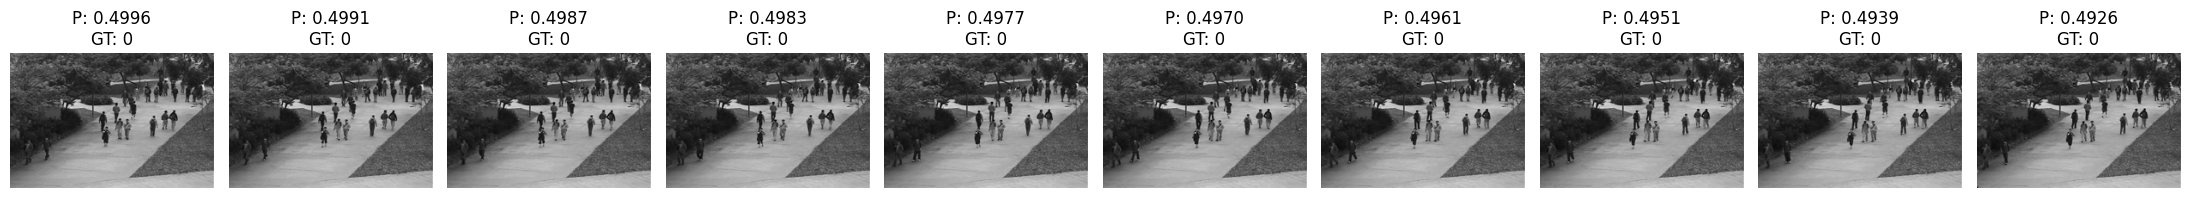

In [29]:
# Get a validation batch
val_batch, val_labels = val_generator[0]

# Generate predictions
predictions = combined_model.predict(val_batch)
print(f"Predictions shape: {predictions.shape}")  # Confirm shape (batch_size, sequence_length, 1)

# Visualize the first sequence in a row
sequence_idx = 0  # Visualizing the first sequence
fig, axes = plt.subplots(1, SEQUENCE_LENGTH, figsize=(22, 8))  # Create a row of subplots

for frame_idx in range(SEQUENCE_LENGTH):
    ax = axes[frame_idx]
    ax.imshow(val_batch[sequence_idx, frame_idx])

    # Extract the scalar prediction for the current frame
    frame_prediction = predictions[sequence_idx, frame_idx, 0]  # Access the scalar inside the 3D prediction array

    ax.set_title(f"P: {frame_prediction:.4f}\nGT: {val_labels[sequence_idx, frame_idx]}")
    ax.axis("off")  # Turn off axis

plt.tight_layout()
plt.show()

### Test the model

In [49]:
# Create the generator for testing data with resized frames
test_generator = TestSequenceGenerator(
    base_path='/content/UCSD_Anomaly_Dataset/UCSDped2/Test',
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
    frame_size=(158, 238)  # Match training dimensions
)

# Test the generator to ensure it's loading data correctly
test_batch, test_labels = test_generator[0]
print(f"Test Batch shape: {test_batch.shape}")  # Should match (batch_size, sequence_length, 158, 238, 3)
print(f"Test Labels shape: {test_labels.shape}")  # Should match (batch_size, sequence_length)

# Generate predictions
predictions = combined_model.predict(test_generator)

# Evaluate on test data for baseline loss and accuracy
loss, accuracy = combined_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Batch shape: (16, 10, 158, 238, 3)
Test Labels shape: (16, 10)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.2523 - loss: 0.7477
Test Loss: 0.8115, Test Accuracy: 0.1885


In [75]:
# Flatten predictions and labels for metric calculations
predicted_labels = predictions.flatten()  # Model outputs probabilities
true_labels = np.concatenate([test_generator[i][1].flatten() for i in range(len(test_generator))])

# Convert probabilities to binary labels (e.g., threshold at 0.5)
binary_predictions = (predicted_labels >= 0.00000000000000000000005).astype(int)

# Calculate Precision, Recall, F1-Score, Accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, binary_predictions, average='binary')
accuracy = (binary_predictions == true_labels).mean()

# Calculate ROC-AUC
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.4344
Precision: 0.8073
Recall: 0.3979
F1 Score: 0.5331
ROC-AUC: 0.4956


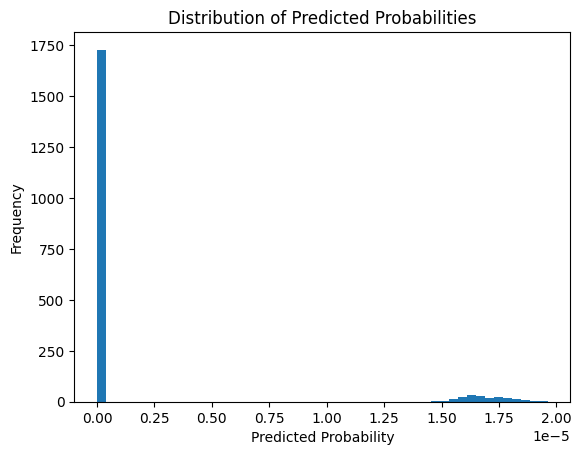

In [64]:
plt.hist(predicted_labels, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

Wow! That's a low threshold. Let's take a deeper look at what's maybe happening here.

### Visualize the Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predictions shape: (16, 10, 1)


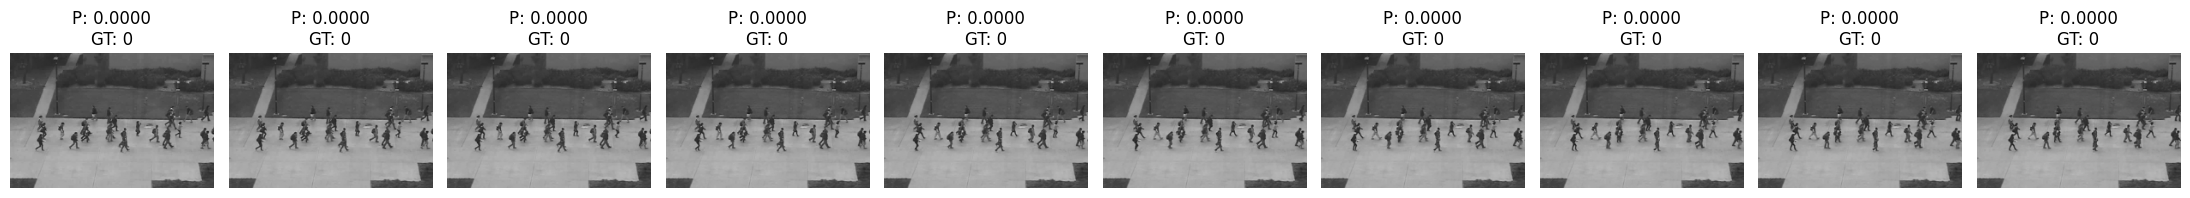

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions for the test batch
predictions = combined_model.predict(test_batch)
print(f"Predictions shape: {predictions.shape}")  # Confirm shape is (batch_size, sequence_length, 1)

# Select a sequence to visualize
sequence_idx = 0
fig, axes = plt.subplots(1, SEQUENCE_LENGTH, figsize=(22, 8))  # Create a row of subplots

for frame_idx in range(SEQUENCE_LENGTH):
    ax = axes[frame_idx]
    ax.imshow(test_batch[sequence_idx, frame_idx])

    # Extract the scalar prediction for the current frame
    frame_prediction = predictions[sequence_idx, frame_idx, 0]  # Access the scalar inside the 3D prediction array

    ax.set_title(f"P: {frame_prediction:.4f}\nGT: {test_labels[sequence_idx, frame_idx]}")
    ax.axis("off")  # Turn off axis

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


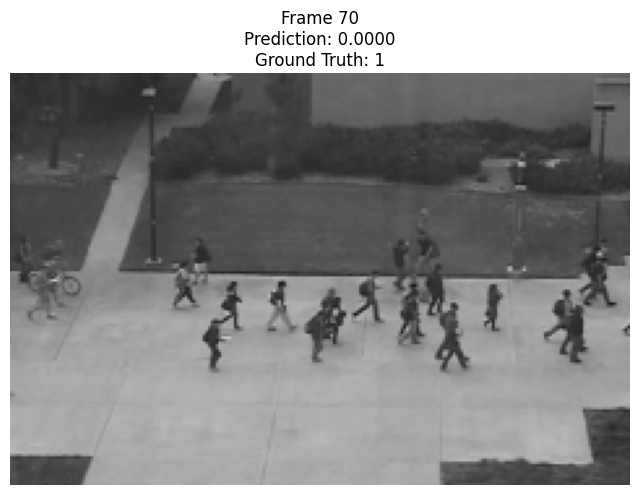

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


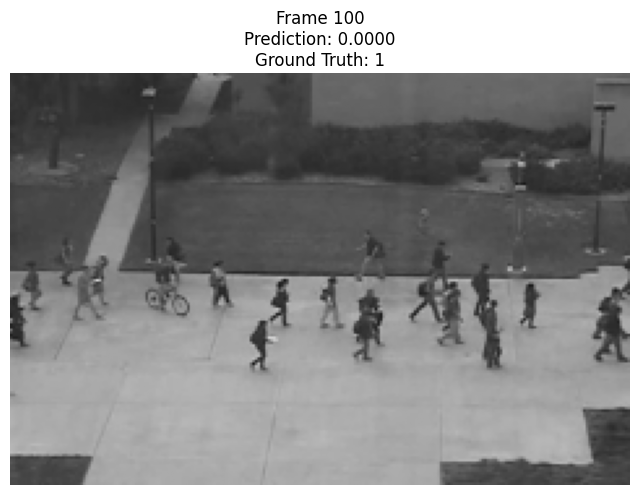

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


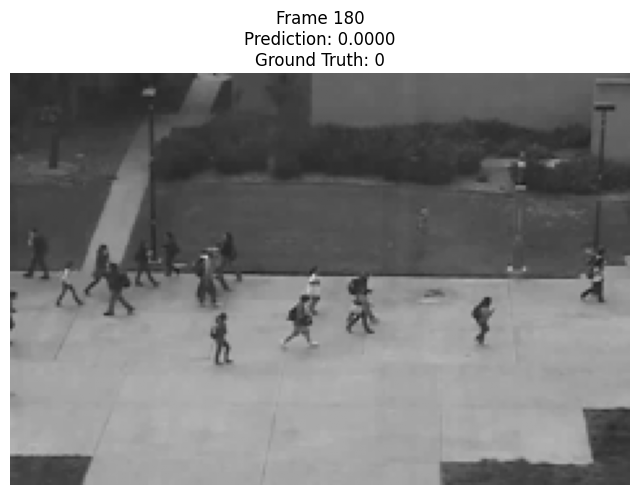

In [ ]:
def visualize_test_frame_by_global_idx(test_generator, combined_model, global_frame_idx):
    """
    Visualize a specific frame from the test set along with its prediction and ground truth
    using a global frame index.

    Parameters:
        test_generator (Sequence): The test generator.
        combined_model (Model): The trained model.
        global_frame_idx (int): The global frame index to visualize.
    """
    # Calculate the batch index and frame index within the batch
    sequence_length = test_generator.sequence_length
    batch_size = test_generator.batch_size
    total_frames = len(test_generator.frame_paths)

    # Ensure the global frame index is within bounds
    if global_frame_idx >= total_frames:
        raise ValueError(f"Frame index {global_frame_idx} exceeds total number of frames {total_frames}")

    batch_idx = global_frame_idx // (batch_size * sequence_length)
    frame_within_batch = (global_frame_idx % (batch_size * sequence_length)) % sequence_length
    sequence_within_batch = (global_frame_idx % (batch_size * sequence_length)) // sequence_length

    # Get the specific batch
    test_batch, test_labels = test_generator[batch_idx]
    predictions = combined_model.predict(test_batch)

    # Extract the specific frame
    frame = test_batch[sequence_within_batch, frame_within_batch]
    frame_prediction = predictions[sequence_within_batch, frame_within_batch, 0]  # Prediction for the frame
    ground_truth = test_labels[sequence_within_batch, frame_within_batch]  # Ground truth for the frame

    # Plot the frame
    plt.figure(figsize=(8, 8))
    plt.imshow(frame)
    plt.title(f"Frame {global_frame_idx}\nPrediction: {frame_prediction:.4f}\nGround Truth: {ground_truth}")
    plt.axis("off")
    plt.show()

visualize_test_frame_by_global_idx(test_generator, combined_model, global_frame_idx=70)
visualize_test_frame_by_global_idx(test_generator, combined_model, global_frame_idx=100)
visualize_test_frame_by_global_idx(test_generator, combined_model, global_frame_idx=180)

In [ ]:
def find_matching_frames(test_generator, combined_model):
    """
    Find and visualize frames where the prediction matches the ground truth of 1 (anomaly).

    Parameters:
        test_generator (Sequence): The test generator.
        combined_model (Model): The trained model.

    Returns:
        List of tuples containing (global_frame_idx, prediction, ground_truth)
    """
    matching_frames = []
    sequence_length = test_generator.sequence_length
    batch_size = test_generator.batch_size
    total_frames = len(test_generator.frame_paths)

    for batch_idx in range(len(test_generator)):
        # Generate the test batch
        test_batch, test_labels = test_generator[batch_idx]
        predictions = combined_model.predict(test_batch)

        for sequence_idx in range(batch_size):
            for frame_idx in range(sequence_length):
                global_frame_idx = batch_idx * batch_size * sequence_length + sequence_idx * sequence_length + frame_idx
                pred = round(predictions[sequence_idx, frame_idx, 0])  # Round the prediction to 0 or 1
                gt = test_labels[sequence_idx, frame_idx]  # Ground truth

                if pred == gt == 1:  # Match where both are 1
                    matching_frames.append((global_frame_idx, pred, gt))

    return matching_frames

matches = find_matching_frames(test_generator, combined_model)
print(f"Matching frames with prediction and ground truth of 1: {matches}")

# Visualize the first match, if any
if matches:
    first_match_idx = matches[0][0]
    visualize_test_frame_by_global_idx(test_generator, combined_model, global_frame_idx=first_match_idx)
else:
    print("No matching frames found.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Matching frames with prediction and ground truth of 1: []
No matching frames found.


In [ ]:
test_batch, test_labels = test_generator[0]
print("Ground Truth Labels:", test_labels)

Ground Truth Labels: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


In [ ]:
for batch_idx in range(len(test_generator)):
    test_batch, test_labels = test_generator[batch_idx]
    predictions = combined_model.predict(test_batch)

    for sequence_idx in range(test_batch.shape[0]):
        for frame_idx in range(test_generator.sequence_length):
            pred = predictions[sequence_idx, frame_idx, 0]
            gt = test_labels[sequence_idx, frame_idx]
            if gt == 1:
                print(f"Frame: {frame_idx}, Prediction: {pred}, Ground Truth: {gt}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Frame: 0, Prediction: 2.350186832700274e-06, Ground Truth: 1
Frame: 1, Prediction: 2.1105396076637195e-12, Ground Truth: 1
Frame: 2, Prediction: 7.40408704551725e-18, Ground Truth: 1
Frame: 3, Prediction: 2.922512100797331e-26, Ground Truth: 1
Frame: 4, Prediction: 2.6932517494006165e-31, Ground Truth: 1
Frame: 5, Prediction: 0.0, Ground Truth: 1
Frame: 6, Prediction: 0.0, Ground Truth: 1
Frame: 7, Prediction: 0.0, Ground Truth: 1
Frame: 8, Prediction: 0.0, Ground Truth: 1
Frame: 9, Prediction: 0.0, Ground Truth: 1
Frame: 0, Prediction: 2.4667244815645972e-06, Ground Truth: 1
Frame: 1, Prediction: 2.412231438903012e-12, Ground Truth: 1
Frame: 2, Prediction: 8.541807803634936e-18, Ground Truth: 1
Frame: 3, Prediction: 3.523259878704659e-26, Ground Truth: 1
Frame: 4, Prediction: 3.7349619126614687e-31, Ground Truth: 1
Frame: 5, Prediction: 0.0, Ground Truth: 1
Frame: 6, Prediction: 0.0, Ground Truth: 1
Frame: 7, Prediction: 0.0, Ground Truth: 1
Fram

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


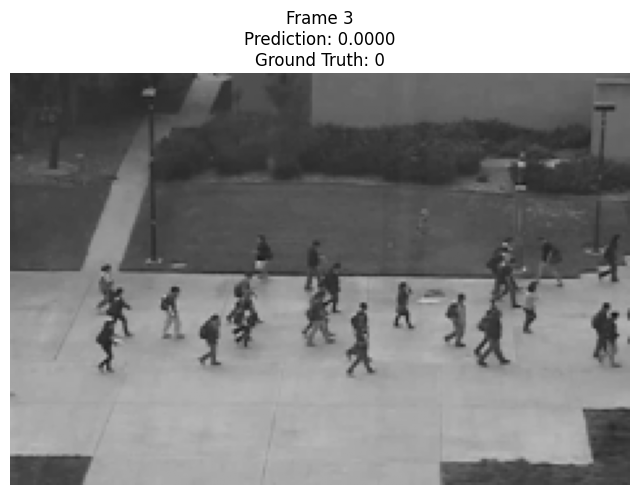

In [ ]:
def visualize_test_frame_by_batch(test_batch, predictions, test_labels, frame_idx):
    """
    Visualize a specific frame from a test batch along with its prediction and ground truth.

    Parameters:
        test_batch (numpy array): The batch of test frames.
        predictions (numpy array): The model's predictions for the test batch.
        test_labels (numpy array): Ground truth labels for the test batch.
        frame_idx (int): The frame index to visualize.
    """
    # Extract the specific frame
    frame = test_batch[0, frame_idx]
    frame_prediction = predictions[0, frame_idx, 0]  # Prediction for the frame
    ground_truth = test_labels[0, frame_idx]  # Ground truth for the frame

    # Plot the frame
    plt.figure(figsize=(8, 8))
    plt.imshow(frame)
    plt.title(f"Frame {frame_idx}\nPrediction: {frame_prediction:.4f}\nGround Truth: {ground_truth}")
    plt.axis("off")
    plt.show()

test_batch, test_labels = test_generator[0]  # First batch
predictions = combined_model.predict(test_batch)
visualize_test_frame_by_batch(test_batch, predictions, test_labels, frame_idx=3)

### Save and Load

In [ ]:
combined_model.save('/content/drive/MyDrive/combined_model_correct.h5')

In [ ]:
# from tensorflow.keras.models import load_model

# loaded_model = load_model('/content/drive/MyDrive/combined_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Anomaly found! Batch: 0, Sequence: 6, Frame: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


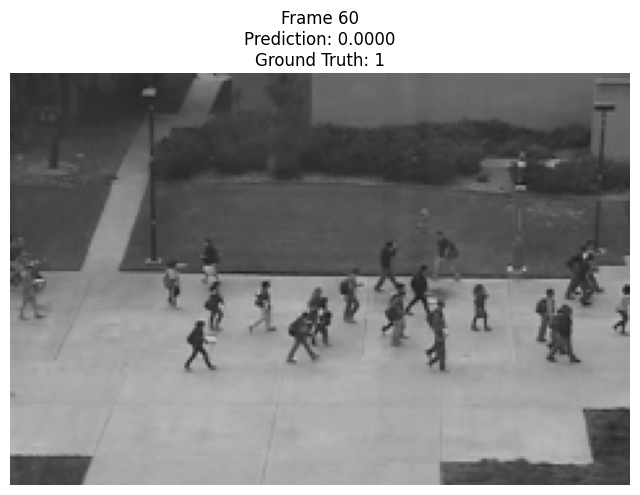

In [ ]:
def find_and_visualize_anomalies(test_generator, combined_model):
    """
    Find frames where the prediction matches the ground truth of 1 and visualize them.

    Parameters:
        test_generator (Sequence): The test generator.
        combined_model (Model): The trained model.
    """
    for batch_idx in range(len(test_generator)):
        test_batch, test_labels = test_generator[batch_idx]
        predictions = combined_model.predict(test_batch)

        for sequence_idx in range(test_batch.shape[0]):
            for frame_idx in range(test_generator.sequence_length):
                if test_labels[sequence_idx, frame_idx] == 1:
                    global_frame_idx = (
                        batch_idx * test_generator.batch_size * test_generator.sequence_length
                        + sequence_idx * test_generator.sequence_length
                        + frame_idx
                    )
                    print(f"Anomaly found! Batch: {batch_idx}, Sequence: {sequence_idx}, Frame: {frame_idx}")
                    visualize_test_frame_by_global_idx(test_generator, combined_model, global_frame_idx)
                    return

find_and_visualize_anomalies(test_generator, combined_model)

### Analysis on 1st LSTM

Our first LSTM model didn’t perform as well as we’d hoped. The test accuracy was just 0.1885, with an F1 Score of 0.5331 and a ROC-AUC of 0.4956—basically random guessing. When we looked at the predicted probabilities, most of them were clustered near zero (as shown in the distribution plot), which made it clear that our model wasn’t picking up on anomalies properly.

What stood out even more was how the frame predictions played out. The anomaly probabilities just kept dropping across consecutive frames, even when the ground truth said they were anomalies. It looks like the model didn’t fully grasp the temporal or spatial relationships in the data, probably because of the inconsistent frame sizes between the datasets.

To fix this, we decided to give our second LSTM model a better shot by resizing all the frames to (160, 240). The idea was to keep things consistent and make it easier for the model to spot spatial patterns while reducing any confusion caused by the original size mismatch. The code below reflects these changes in architecutre as well as attempted to measure a large range of metrics during training.

### Second Attempt at Endocder/ConvLSTM

#### 2nd LSTM Model Architecture

In [124]:
# Parameters
FRAME_SIZE = (160, 240)  # New common frame size
BATCH_SIZE = 16
SEQUENCE_LENGTH = 10
input_shape = (FRAME_SIZE[0], FRAME_SIZE[1], 3)  # (Height, Width, Channels)

# Recalculate feature shape for the temporal model
# feature_shape = (input_shape[0] // 32, input_shape[1] // 32, 64)  # Adjust for spatial reduction
# Dynamically calculate feature_shape based on the encoder's output
dummy_frame = tf.random.normal((1, *FRAME_SIZE, 3))
dummy_encoded = encoder(dummy_frame)
feature_shape = dummy_encoded.shape[1:]  # Extract the spatial dimensions and channels
print(f"Dynamic feature shape: {feature_shape}")

Dynamic feature shape: (4, 8, 64)


In [125]:
def build_encoder(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pretrained layers

    # Encoder model
    encoder = models.Sequential([
        base_model,
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Keep spatial info
        layers.MaxPooling2D((2, 2), strides=(2, 2)),  # Reduce spatial dimensions
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add another conv layer
        layers.UpSampling2D((2, 2))  # Slightly upsample to adjust spatial mismatch
    ])
    return encoder

encoder = build_encoder(input_shape)
encoder.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 5, 8, 64)            │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 2, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_38 (UpSampling2D)      │ (None, 4, 8, 64)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,804,352 (94.62 MB)

 Trainable params: 1,216,640 (4.64 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [126]:
def build_decoder(latent_shape):
    decoder = models.Sequential([
        layers.Input(shape=latent_shape),
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Upsample to (8, 16)
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Upsample to (16, 32)
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((10, 7)),  # Upsample to (160, 240)
        layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')  # Reconstruct final frame
    ])
    return decoder

decoder = build_decoder(latent_shape)
decoder.summary()


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_40                  │ (None, 4, 8, 128)           │          73,856 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_39 (UpSampling2D)      │ (None, 8, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_41                  │ (None, 8, 16, 64)           │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_40 (UpSampling2D)      │ (None, 16, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_42                  │ (None, 16, 32, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_41 (UpSampling2D)      │ (None, 160, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_43                  │ (None, 160, 224, 3)         │             867 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,979 (652.26 KB)

 Trainable params: 166,979 (652.26 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
def build_temporal_model(sequence_length, latent_shape):
    model = models.Sequential([
        # Temporal modeling with ConvLSTM2D
        layers.ConvLSTM2D(64, (3, 3), activation='relu', padding='same', return_sequences=True,
                          input_shape=(sequence_length, *latent_shape)),
        layers.ConvLSTM2D(32, (3, 3), activation='relu', padding='same', return_sequences=True),  # Keep return_sequences=True

        # Spatial anomaly scoring with Conv2D
        layers.TimeDistributed(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')),  # Score for each frame

        # Average spatial anomaly scores for each frame
        layers.TimeDistributed(layers.GlobalAveragePooling2D())  # Score per frame
    ])
    return model

# Recalculate latent_shape based on the new FRAME_SIZE
latent_shape = feature_shape
temporal_model = build_temporal_model(SEQUENCE_LENGTH, latent_shape)
temporal_model.summary()


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_22 (ConvLSTM2D)          │ (None, 10, 4, 8, 64)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_23 (ConvLSTM2D)          │ (None, 10, 4, 8, 32)        │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_52                  │ (None, 10, 4, 8, 1)         │             289 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_53                  │ (None, 10, 1)               │               0 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,177 (1.55 MB)

 Trainable params: 406,177 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
def build_combined_model(encoder, decoder, temporal_model, sequence_length):
    inputs = layers.Input(shape=(sequence_length, FRAME_SIZE[0], FRAME_SIZE[1], 3))  # Adjusted frame dimensions

    # Apply encoder to compress frames
    encoded_frames = layers.TimeDistributed(encoder)(inputs)  # Shape: (None, 10, feature_shape[0], feature_shape[1], 64)

    # Apply temporal model to detect anomalies in encoded frames
    temporal_scores = temporal_model(encoded_frames)  # Shape: (None, 10, 1)

    # Decode frames for reconstruction (if needed)
    reconstructed_frames = layers.TimeDistributed(decoder)(encoded_frames)  # Shape: (None, 10, FRAME_SIZE[0], FRAME_SIZE[1], 3)

    # Define the model
    model = Model(inputs, temporal_scores)
    return model

# Combined model
combined_model = build_combined_model(encoder, decoder, temporal_model, SEQUENCE_LENGTH)
combined_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',  # Overall accuracy
        Precision(name='precision'),  # Precision metric
        Recall(name='recall'),  # Recall metric
        AUC(name='auc_roc', curve='ROC'),  # ROC AUC
        AUC(name='auc_pr', curve='PR')  # Precision-Recall AUC
    ]
)
combined_model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_57 (InputLayer)          │ (None, 10, 160, 240, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_56                  │ (None, 10, 4, 8, 64)        │      24,804,352 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_31 (Sequential)           │ (None, 10, 1)               │         406,177 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,210,529 (96.17 MB)

 Trainable params: 1,622,817 (6.19 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### 2nd LSTM Attempt at Generators

In [160]:
class MultiDatasetSequenceGenerator(Sequence):
    def __init__(self, base_paths, sequence_length, batch_size, frame_size):
        self.base_paths = base_paths  # List of dataset paths
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.frame_size = frame_size

        # Collect all frame paths from each dataset
        self.frame_paths = self._get_frame_paths()

    def _get_frame_paths(self):
        frame_paths = []
        for base_path in self.base_paths:
            video_folders = sorted([os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])
            for folder in video_folders:
                tif_files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')])
                frame_paths.extend(tif_files)
        return frame_paths

    def __len__(self):
        return len(self.frame_paths) // (self.batch_size * self.sequence_length)

    def __getitem__(self, idx):
        batch_frames = []
        batch_labels = []
        for i in range(self.batch_size):
            start_idx = (idx * self.batch_size + i) * self.sequence_length
            sequence = []
            labels = []
            for j in range(self.sequence_length):
                frame_path = self.frame_paths[start_idx + j]
                frame = cv2.imread(frame_path, cv2.IMREAD_COLOR)
                frame = cv2.resize(frame, (self.frame_size[1], self.frame_size[0])) / 255.0  # Normalize frame

                # Generate random or dummy labels (e.g., all frames are normal)
                labels.append(0)  # All normal for training frames

                sequence.append(frame)
            batch_frames.append(sequence)
            batch_labels.append(labels)

        # Expand the labels to match model output
        return np.array(batch_frames), np.expand_dims(np.array(batch_labels), axis=-1)


In [161]:
class TestSequenceGenerator(Sequence):
    def __init__(self, base_path, sequence_length, batch_size, frame_size):
        self.base_path = base_path
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.frame_size = frame_size  # (height, width)

        # List all video folders (excluding *_gt folders)
        self.video_folders = sorted(
            [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f)) and not f.endswith("_gt")]
        )

        self.frame_paths = self._get_frame_paths()
        self.gt_paths = self._get_gt_paths()

        # Check mismatch between frame_paths and gt_paths
        if len(self.frame_paths) != len(self.gt_paths):
            print(f"Warning: Mismatch between frame paths ({len(self.frame_paths)}) and GT paths ({len(self.gt_paths)})")
            min_len = min(len(self.frame_paths), len(self.gt_paths))
            self.frame_paths = self.frame_paths[:min_len]
            self.gt_paths = self.gt_paths[:min_len]

    def _get_frame_paths(self):
        frame_paths = []
        for folder in self.video_folders:
            tif_files = sorted(
                [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tif')]
            )
            frame_paths.extend(tif_files)
        return frame_paths

    def _get_gt_paths(self):
        gt_paths = []
        for folder in self.video_folders:
            gt_folder = folder + "_gt"  # Append "_gt" to each video folder name
            if os.path.exists(gt_folder):
                bmp_files = sorted(
                    [os.path.join(gt_folder, f) for f in os.listdir(gt_folder) if f.endswith('.bmp')]
                )
                gt_paths.extend(bmp_files)
            else:
                print(f"Warning: GT folder not found for {folder}")
        return gt_paths

    def __len__(self):
        return len(self.frame_paths) // (self.batch_size * self.sequence_length)

    def __getitem__(self, idx):
        batch_frames = []
        batch_labels = []
        for i in range(self.batch_size):
            start_idx = (idx * self.batch_size + i) * self.sequence_length
            sequence = []
            labels = []
            for j in range(self.sequence_length):
                frame_path = self.frame_paths[start_idx + j]
                frame = cv2.imread(frame_path, cv2.IMREAD_COLOR)
                frame = cv2.resize(frame, (self.frame_size[1], self.frame_size[0])) / 255.0  # Normalize frame

                # Handle missing GT masks
                if start_idx + j < len(self.gt_paths):
                    gt_mask_path = self.gt_paths[start_idx + j]
                    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
                    gt_mask = cv2.resize(gt_mask, (self.frame_size[1], self.frame_size[0]))  # Resize GT mask
                    # labels.append(gt_mask)  # Append the resized mask
                    labels.append(1 if gt_mask.max() > 0 else 0)
                else:
                    # if no GT mask exists
                    # labels.append(np.zeros((self.frame_size[0], self.frame_size[1])))
                    labels.append(0)

                sequence.append(frame)
            batch_frames.append(sequence)
            batch_labels.append(labels)
        # return np.array(batch_frames), np.array(batch_labels)
        return np.array(batch_frames), np.expand_dims(np.array(batch_labels), axis=-1)

In [168]:
# Create the generator for training data (UCSDped1 + UCSDped2 train sets)
train_generator = MultiDatasetSequenceGenerator(
    base_paths=[
        '/content/UCSD_Anomaly_Dataset/UCSDped1/Train',
        '/content/UCSD_Anomaly_Dataset/UCSDped2/Train'
    ],
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
    frame_size=FRAME_SIZE
)

# Test the training generator
sample_batch, _ = train_generator[0]
print(f"Training Batch shape: {sample_batch.shape}")  # Should be (batch_size, sequence_length, FRAME_SIZE[0], FRAME_SIZE[1], 3)

Training Batch shape: (16, 10, 160, 240, 3)


In [169]:
# Create the generator for validation data (UCSDped1 test set)
val_generator = TestSequenceGenerator(
    base_path='/content/UCSD_Anomaly_Dataset/UCSDped1/Test',
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
    frame_size=FRAME_SIZE
)

# Test the validation generator
val_batch, val_labels = val_generator[0]
print(f"Validation Batch shape: {val_batch.shape}")  # Should be (batch_size, sequence_length, FRAME_SIZE[0], FRAME_SIZE[1], 3)
print(f"Validation Labels shape: {val_labels.shape}")  # Should be (batch_size, sequence_length)

sample_batch, _ = val_generator[0]
print(f"Val Batch shape: {sample_batch.shape}")  # Should be (batch_size, sequence_length, FRAME_SIZE[0], FRAME_SIZE[1], 3)

Validation Batch shape: (16, 10, 160, 240, 3)
Validation Labels shape: (16, 10, 1)
Val Batch shape: (16, 10, 160, 240, 3)


In [170]:
train_batch, train_labels = next(iter(train_generator))
print(f"Train batch shape: {train_batch.shape}")
print(f"Train labels shape: {train_labels.shape}")

val_batch, val_labels = next(iter(val_generator))
print(f"Validation batch shape: {val_batch.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Train batch shape: (16, 10, 160, 240, 3)
Train labels shape: (16, 10, 1)
Validation batch shape: (16, 10, 160, 240, 3)
Validation labels shape: (16, 10, 1)


Sanity Check (Confirming Validation is correctly labeled)

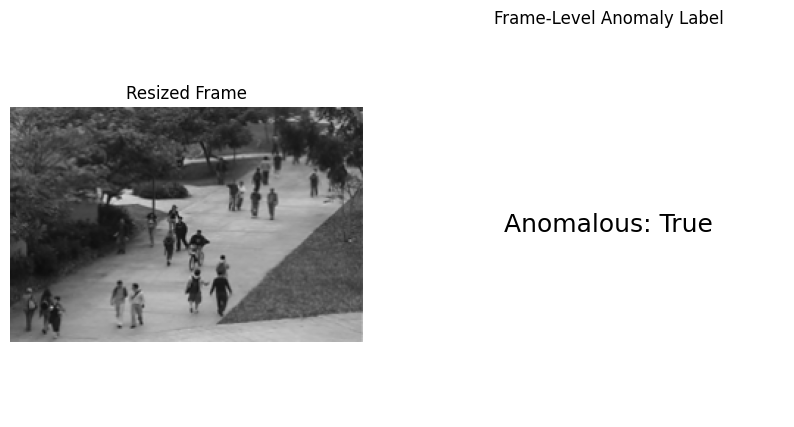

In [171]:
plt.figure(figsize=(10, 5))

# Display the frame
plt.subplot(1, 2, 1)
plt.imshow(val_batch[12, 2])  # Frame 9 in sequence 15
plt.title("Resized Frame")
plt.axis("off")

# Display the binary anomaly label
plt.subplot(1, 2, 2)
plt.text(
    0.5, 0.5,
    f"Anomalous: {bool(val_labels[12, 2])}",
    fontsize=18,
    ha='center', va='center'
)
plt.title("Frame-Level Anomaly Label")
plt.axis("off")

plt.show()

#### 2nd LSTM Training

In [172]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# class DebugCallback(tf.keras.callbacks.Callback):
#     def on_train_batch_begin(self, batch, logs=None):
#         print(f"Batch {batch} started.")
#     def on_train_batch_end(self, batch, logs=None):
#         print(f"Batch {batch} ended. Logs: {logs}")

callbacks = [early_stopping, reduce_lr]#, DebugCallback()]

try:
    combined_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        verbose=1,
        callbacks=callbacks
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise

Epoch 1/20


58/58 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.9210 - auc_pr: 0.0000e+00 - auc_roc: 0.0000e+00 - loss: 0.1662 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3568 - val_auc_pr: 0.6432 - val_auc_roc: 0.5000 - val_loss: 10.0647 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - auc_pr: 0.0000e+00 - auc_roc: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 1.0000 - auc_pr: 0.0000e+00 - auc_roc: 0.0000e+00 - loss: 4.2434e-07 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3568 - val_auc_pr: 0.6432 - val_auc_roc: 0.5000 - val_loss: 10.3328 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - auc_pr: 0.0000e+00 - auc_roc: 0.0000e+00 - loss: 0.0000

#### 2nd LSTM Testing

In [177]:
# Create the generator for testing data with resized frames
test_generator = TestSequenceGenerator(
    base_path='/content/UCSD_Anomaly_Dataset/UCSDped2/Test',
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
    frame_size=(160, 240)  # Match training dimensions
)

# Test the generator to ensure it's loading data correctly
test_batch, test_labels = test_generator[0]
print(f"Test Batch shape: {test_batch.shape}")  # Should match (batch_size, sequence_length, 158, 238, 3)
print(f"Test Labels shape: {test_labels.shape}")  # Should match (batch_size, sequence_length)

# Generate predictions
predictions = combined_model.predict(test_generator)

# Evaluate on test data for baseline loss and accuracy (Increased the number of metrics)
# loss, accuracy = combined_model.evaluate(test_generator, verbose=1)
# print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Batch shape: (16, 10, 160, 240, 3)
Test Labels shape: (16, 10, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step


In [183]:
# Evaluate on test data and unpack all metrics
results = combined_model.evaluate(test_generator, verbose=1)
metrics = dict(zip(combined_model.metrics_names, results))

12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.2523 - auc_pr: 0.7477 - auc_roc: 0.5000 - loss: 12.0294 - precision: 0.0000e+00 - recall: 0.0000e+00


In [185]:
print(f"Available metrics: {metrics}")

Available metrics: {'loss': 13.054854393005371, 'compile_metrics': 0.18854166567325592}


#### Final Metrics for 2nd LSTM

In [186]:
# Flatten predictions and labels for metric calculations
predicted_labels = predictions.flatten()  # Model outputs probabilities
true_labels = np.concatenate([test_generator[i][1].flatten() for i in range(len(test_generator))])

# Convert probabilities to binary labels (e.g., threshold at 0.5)
binary_predictions = (predicted_labels >= 0.00000000000000000000005).astype(int)

# Calculate Precision, Recall, F1-Score, Accuracy
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, binary_predictions, average='binary')
accuracy = (binary_predictions == true_labels).mean()

# Calculate ROC-AUC
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.3115
Precision: 0.8073
Recall: 0.1990
F1 Score: 0.3193
ROC-AUC: 0.4968


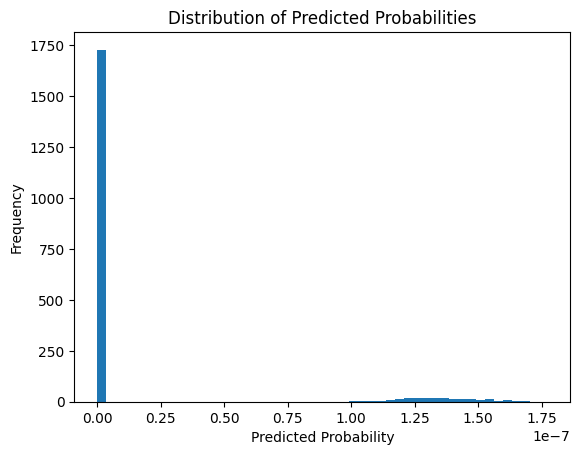

In [191]:
plt.hist(predicted_labels, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
Predictions shape: (16, 10, 1)


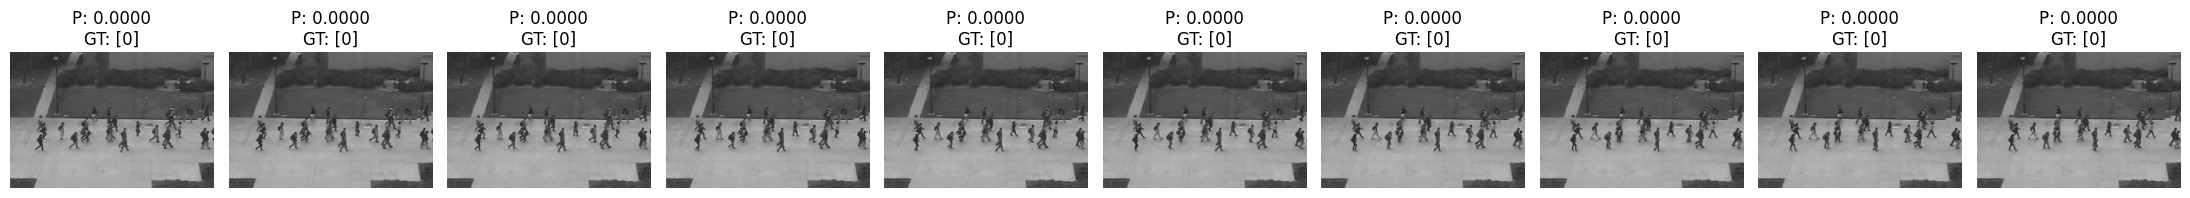

In [188]:
# Generate predictions for the test batch
predictions = combined_model.predict(test_batch)
print(f"Predictions shape: {predictions.shape}")  # Confirm shape is (batch_size, sequence_length, 1)

# Select a sequence to visualize
sequence_idx = 0
fig, axes = plt.subplots(1, SEQUENCE_LENGTH, figsize=(22, 8))  # Create a row of subplots

for frame_idx in range(SEQUENCE_LENGTH):
    ax = axes[frame_idx]
    ax.imshow(test_batch[sequence_idx, frame_idx])

    # Extract the scalar prediction for the current frame
    frame_prediction = predictions[sequence_idx, frame_idx, 0]  # Access the scalar inside the 3D prediction array

    ax.set_title(f"P: {frame_prediction:.4f}\nGT: {test_labels[sequence_idx, frame_idx]}")
    ax.axis("off")  # Turn off axis

plt.tight_layout()
plt.show()

In [189]:
for batch_idx in range(len(test_generator)):
    test_batch, test_labels = test_generator[batch_idx]
    predictions = combined_model.predict(test_batch)

    for sequence_idx in range(test_batch.shape[0]):
        for frame_idx in range(test_generator.sequence_length):
            pred = predictions[sequence_idx, frame_idx, 0]
            gt = test_labels[sequence_idx, frame_idx]
            if gt == 1:
                print(f"Frame: {frame_idx}, Prediction: {pred}, Ground Truth: {gt}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Frame: 0, Prediction: 1.2299825868922198e-07, Ground Truth: [1]
Frame: 1, Prediction: 1.4300273614398366e-17, Ground Truth: [1]
Frame: 2, Prediction: 2.933914130884013e-29, Ground Truth: [1]
Frame: 3, Prediction: 0.0, Ground Truth: [1]
Frame: 4, Prediction: 0.0, Ground Truth: [1]
Frame: 5, Prediction: 0.0, Ground Truth: [1]
Frame: 6, Prediction: 0.0, Ground Truth: [1]
Frame: 7, Prediction: 0.0, Ground Truth: [1]
Frame: 8, Prediction: 0.0, Ground Truth: [1]
Frame: 9, Prediction: 0.0, Ground Truth: [1]
Frame: 0, Prediction: 1.249275243253578e-07, Ground Truth: [1]
Frame: 1, Prediction: 1.5201518324638167e-17, Ground Truth: [1]
Frame: 2, Prediction: 3.1923459432512757e-29, Ground Truth: [1]
Frame: 3, Prediction: 0.0, Ground Truth: [1]
Frame: 4, Prediction: 0.0, Ground Truth: [1]
Frame: 5, Prediction: 0.0, Ground Truth: [1]
Frame: 6, Prediction: 0.0, Ground Truth: [1]
Frame: 7, Prediction: 0.0, Ground Truth: [1]
Frame: 8, Prediction: 0.0, Ground Truth: [

### Analysis on 2nd LSTM

For our second LSTM model, resizing the frames to a consistent (160, 240) format brought only marginal improvement. The accuracy increased slightly to 0.3115, but the F1 Score dropped to 0.3193, and the ROC-AUC barely moved at 0.4968. Precision remained high at 0.8073, but recall was dismal at 0.1990, indicating that while the model correctly classified the few anomalies it did detect, it missed the vast majority.

Looking at the distribution of predicted probabilities, the results were still heavily skewed toward near-zero predictions. Even after resizing the frames, the model struggled to distinguish anomalous frames, often outputting probabilities that failed to separate normal from anomalous patterns effectively. This suggests that the resizing alone wasn’t enough to help the model capture the motion and spatial features necessary for anomaly detection.

The frame-level predictions showed a similar issue as before—predictions quickly dropped off to zero, even for frames labeled as anomalous in the ground truth. While the resizing addressed frame size mismatches, for this kind of Enconder & LSTM model it’s clear that more advanced preprocessing or architectural changes are needed to extract meaningful anomaly patterns.

# Conclusion

Our project explored two approaches to anomaly detection in video sequences using the UCSD dataset: a traditional autoencoder (Model 1) and a hybrid convolutional autoencoder with ConvLSTM layers (Model 2). Both models highlighted unique challenges we discussed in EDA, particularly in handling the dataset's inconsistencies, such as its grainy footage, resolution discrepancies, and class imbalance.

Model 1 stuck to frame-by-frame reconstruction, which worked okay for spatial features. It could flag some anomalies, but without any sense of motion or patterns over time, it didn’t stand a chance at catching dynamic behaviors like bikes weaving through crowds. The training setup was straightforward since it only needed the train dataset split into train/validation sets, and evaluation relied on reconstruction loss. It was simple, but that simplicity was its biggest limitation when dealing with sequential data.

Model 2 was supposed to solve that by adding temporal analysis with ConvLSTM layers, and while it technically worked, the results were underwhelming. Even after resizing all frames to a consistent (160, 240) format to handle dataset inconsistencies, the metrics barely budged. The model was overconfident in rejecting anomalies, often predicting zero probabilities even for frames labeled as anomalous. Using the ground truth for validation added another layer of complexity—it wasn’t just hard to align correctly, but it exposed how the model still struggled to generalize patterns across sequences.

In the end, Model 1 was better for simpler tasks, while Model 2 hinted at more potential for sequence-based anomaly detection but fell short due to dataset issues and architectural hurdles. Going forward, we’d need smarter preprocessing, better ground truth handling, and maybe a shift to models like YOLO or something attention-based to really tackle these challenges head-on.

# Appendix

### Supporting Function

In [192]:
# Parse the .m file for frame-level annotations
def parse_matlab_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    annotations = []
    for line in lines:
        if "gt_frame" in line:
            match = re.search(r'gt_frame = \[(.*)\];', line)
            if match:
                frames = match.group(1)
                frame_ranges = []
                for part in frames.split(','):
                    if ':' in part:
                        start, end = map(int, part.split(':'))
                        frame_ranges.extend(range(start, end + 1))
                    else:
                        frame_ranges.append(int(part))
                annotations.append(frame_ranges)
    return annotations

gt_frames = parse_matlab_file('/content/UCSD_Anomaly_Dataset/UCSDped1/Test/UCSDped1.m')
print(gt_frames)

[[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 1